<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/Disentangled_Latent_space_for_MRI_Harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

* Download necessary libraries
* Declare the folder paths of Images T1 and T2 and get their paths in list

Credits: 
1. A Disentangled latent space for cross-site MRI Harmonization: Dewey, B. et al. “A Disentangled Latent Space for Cross-Site MRI Harmonization.” MICCAI (2020).

2. IXI Dataset: https://brain-development.org/ixi-dataset/


In [1]:
# !pip install --upgrade nibabel
!pip install torchviz
!pip install wandb --upgrade
!pip install intensity-normalization

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=9e4bd022c339572e037c905a2fd3a03a763ca51b60903ba49f2eae652a067017
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz
     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 133kB 19.0MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 174kB 19.5MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=3065a0c567a5d5a7c7f914fc690b485d73f1d8e5986982bf391b7557405c09aa
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=1a41e36b3facd8f165a4a1569ef23de380819570ef82f36433cb4be5831a5f69
  Stored i

In [2]:
import warnings
import os
warnings.filterwarnings("ignore")
import numpy as np
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import nibabel as nb
import os, sys, glob
from google.colab import drive
drive.mount('/content/drive')
print()

1.8.1+cu101
0.9.1+cu101
Mounted at /content/drive



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections
from torch.autograd import Variable
import scipy.misc
import imageio
import warnings
warnings.filterwarnings("ignore")

In [4]:
import wandb
os.environ["WANDB_API_KEY"] = "4d55d2ea028525eadeb537494a02bf9ce8ead8f3"
wandb.login()

import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from torchviz import make_dot
import urllib
from random import randint, seed
seed(1)

wandb: Currently logged in as: suraj110693 (use `wandb login --relogin` to force relogin)


In [5]:
import intensity_normalization

In [6]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
#data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/" 
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2_Train_50_Reg_downsampled_hm_znm/"
#data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2-T1/"
ixi_xls_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/IXI.xls"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))


In [7]:
file_names_t1[0:3]

['/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI060-Guys-0709-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI428-Guys-0996-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI429-Guys-0997-T1_downsampled_hm_zscore.nii.gz']

In [8]:
file_names_t2[0:3]

['/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2_Train_50_Reg_downsampled_hm_znm/reg_IXI430-IOP-0990-T2_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2_Train_50_Reg_downsampled_hm_znm/reg_IXI438-HH-2155-T2_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2_Train_50_Reg_downsampled_hm_znm/reg_IXI439-HH-2114-T2_downsampled_hm_zscore.nii.gz']

In [9]:
ixi_df = pd.read_excel(ixi_xls_path, sheet_name="Table")
ixi_df.head()

IXI_ID  SEX_ID (1=m, 2=f)  HEIGHT  ...  DATE_AVAILABLE  STUDY_DATE        AGE
0       1                  1     170  ...               0         NaT        NaN
1       2                  2     164  ...               1  2005-11-18  35.800137
2      12                  1     175  ...               1  2005-06-01  38.781656
3      13                  1     182  ...               1  2005-06-01  46.710472
4      14                  2     163  ...               1  2005-06-09  34.236824

[5 rows x 12 columns]

In [10]:
ixi_df.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=True)

In [11]:
count = 0
ixi_id = []
scanner_name = []
contrast_type = []
file_path = []
for root, dirs, files in os.walk(data_path_t1):
  for file in files:
    parameters_search = re.search('reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
    if parameters_search:
      ixi_id.append(int(parameters_search.group(1)))
      scanner_name.append(parameters_search.group(2))
      contrast_type.append(parameters_search.group(4))
      file_path.append(os.path.join(data_path_t1, file))
  
    count = count+1
  
  print("processed T1 {} files".format(count))

for root, dirs, files in os.walk(data_path_t2):
  for file in files:
    parameters_search = re.search('reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
    if parameters_search:
      ixi_id.append(int(parameters_search.group(1)))
      scanner_name.append(parameters_search.group(2))
      # contrast_type.append(parameters_search.group(4))
      contrast_type.append("T2")
      file_path.append(os.path.join(data_path_t2, file))
  
    count = count+1
  
  print("processed T2 {} files".format(count))

processed T1 201 files
processed T2 250 files


In [12]:
our_df = pd.DataFrame(data={"our_ixi_id": ixi_id, "scanner_name": scanner_name, "contrast_type": contrast_type, "file_path": file_path} )
our_df.head()

our_ixi_id  ...                                          file_path
0         433  ...  /content/drive/My Drive/Image_Registration_Pro...
1         429  ...  /content/drive/My Drive/Image_Registration_Pro...
2         431  ...  /content/drive/My Drive/Image_Registration_Pro...
3         430  ...  /content/drive/My Drive/Image_Registration_Pro...
4         432  ...  /content/drive/My Drive/Image_Registration_Pro...

[5 rows x 4 columns]

In [13]:
filtered_df = pd.merge(left = ixi_df, right=our_df, left_on="IXI_ID", right_on="our_ixi_id", how="inner")

In [14]:
filtered_df.columns = ['IXI_ID', 'SEX_ID', 'HEIGHT', 'WEIGHT', 'ETHNIC_ID',
       'MARITAL_ID', 'OCCUPATION_ID', 'QUALIFICATION_ID', 'DOB',
       'DATE_AVAILABLE', 'STUDY_DATE', 'AGE', 'our_ixi_id', 'scanner_name',
       'contrast_type', 'file_path']

In [15]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
filtered_df['age_disc'] = pd.cut(filtered_df['AGE'], bins=bins, labels=labels)

# Dataset Analyses
* Plot number of T1 and T2, We need to have equal T1 matching pairs with T2 - Do Not Run


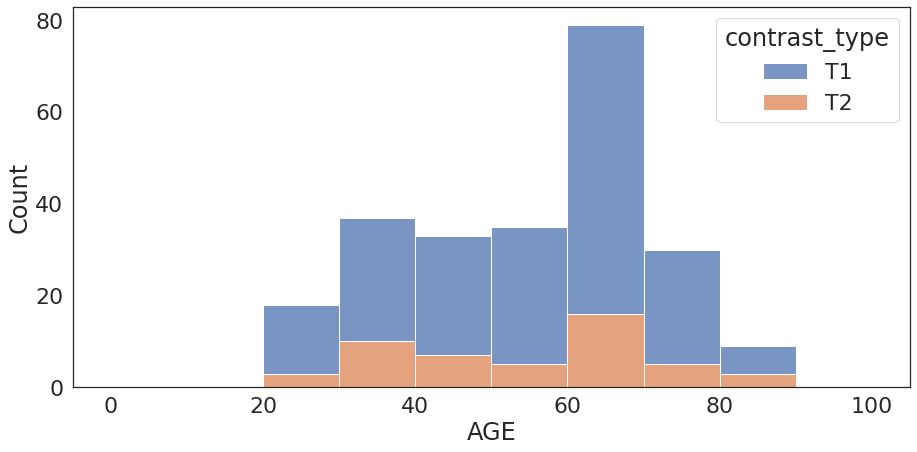

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="contrast_type", multiple="stack", binwidth=10, binrange=(0,100))

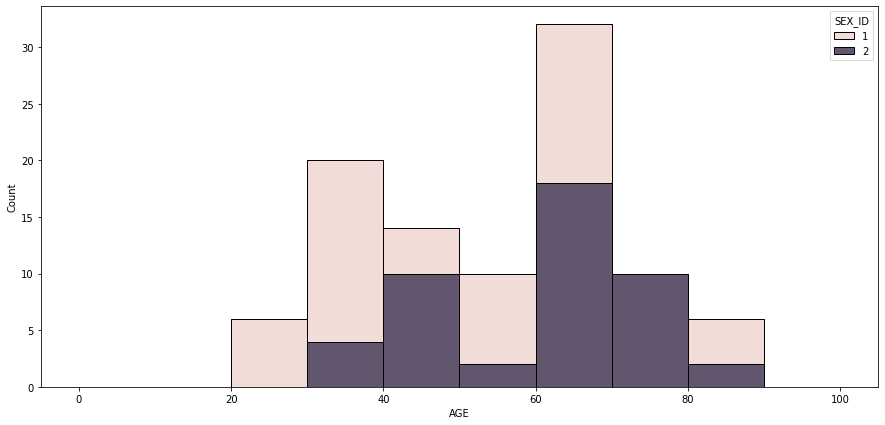

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="SEX_ID", multiple="stack", binwidth=10, binrange=(0,100))

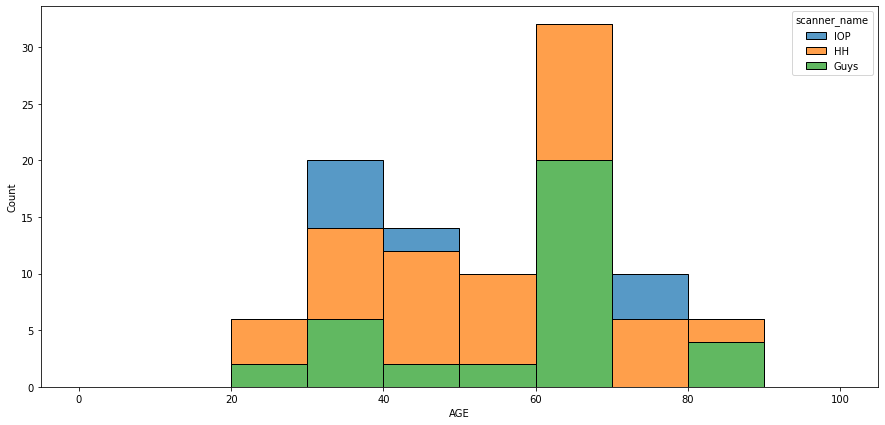

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="scanner_name", multiple="stack", binwidth=10, binrange=(0,100))

# Align T1 and T2 - Do Not Run

In [ ]:
def load_4D(name, slicenum=64):
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        x_dim, y_dim, z_dim = X_np.shape

        X_np = np.array(X_np)

        #use min to remove error due to normalization
        model_np = np.full((128, 128, 128), X_np.min())
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, slicenum ]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def load_3D(name):
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        model_np = np.expand_dims(X_np, axis=0)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

def create_full_brain_mask(img_np):
  img_cp_np = np.copy(img_np)
  image_shape = img_cp_np.shape
  min_intensity = np.min(img_cp_np)
  max_intensity = np.max(img_cp_np)
  img_cp_np[img_cp_np > 0.0] = 1.0
  img_cp_np[img_cp_np <= 0.0] = 0.0
  return img_cp_np

In [ ]:
# data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/" 
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2_Train_50_Reg_downsampled_hm_znm/"
#data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2-T1/"
ixi_xls_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/IXI.xls"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))


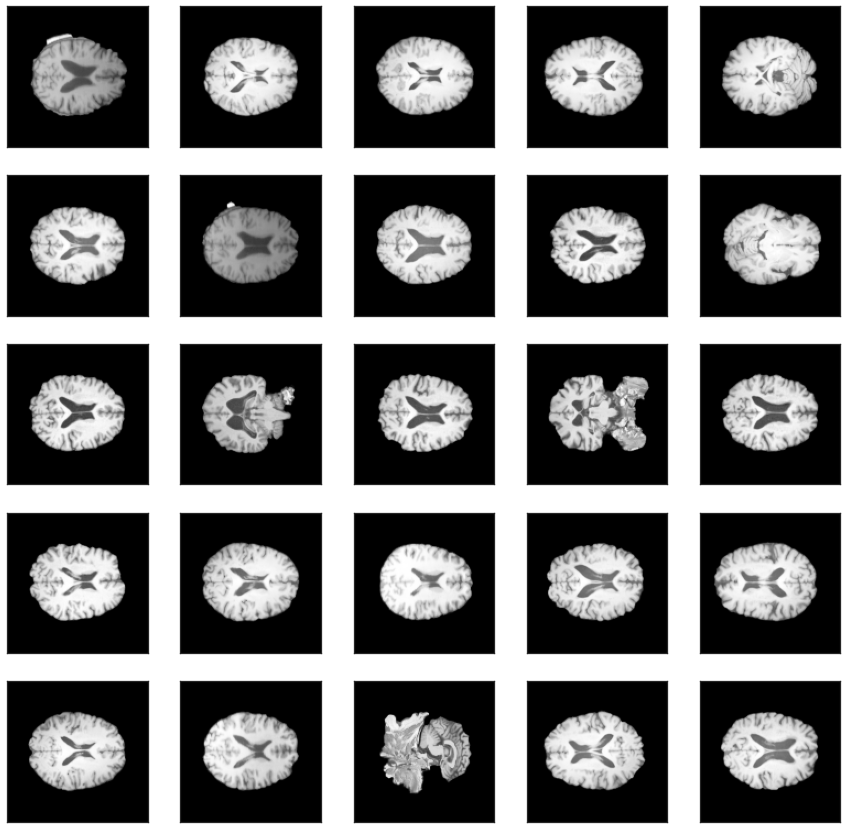

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, 25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  o1 = imgnorm( load_4D(file_names_t1[i+0]) )
  plt.imshow(o1[0, :,:], cmap="Greys_r")
plt.show()

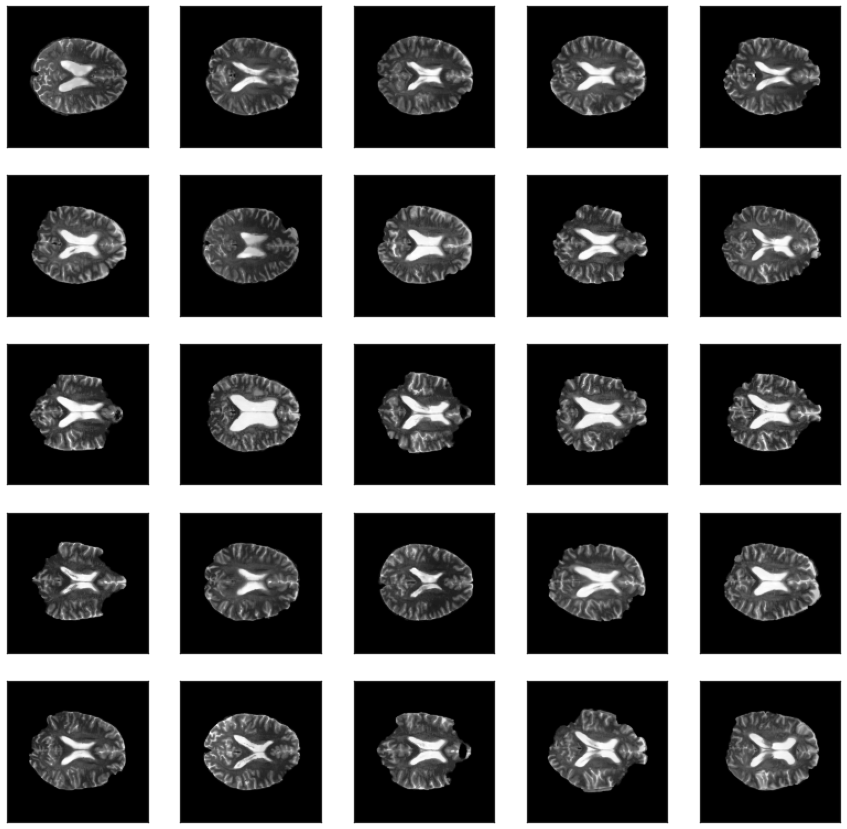

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, 25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  o1 = imgnorm( load_4D(file_names_t2[i+0]) )
  plt.imshow(o1[0, :,:], cmap="Greys_r")
plt.show()

In [ ]:
t2_bad_images_index = [4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48 ]

# FCM white matter to 0.25, Create brain masks - Do Not Run

In [ ]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/" 
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))

In [ ]:
input_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/input_images"
input_nifti_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/input_nifti_images"
mask_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask"
mask_nifti_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask_nifti"
output_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/output_images"

In [ ]:
my_t1_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_output"
my_t2_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T2_1_output"
file_names_my_t1 = sorted(glob.glob(os.path.join(my_t1_path, "*.nii.gz")))
file_names_my_t2 = sorted(glob.glob(os.path.join(my_t2_path, "*.nii.gz")))

In [ ]:
def load_4D(name, slicenum=64):
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        x_dim, y_dim, z_dim = X_np.shape

        X_np = np.array(X_np)

        #use min to remove error due to normalization
        model_np = np.full((128, 128, 128), X_np.min())
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, slicenum ]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def load_3D(name):
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        model_np = np.expand_dims(X_np, axis=0)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

def create_full_brain_mask(img_np):
  img_cp_np = np.copy(img_np)
  image_shape = img_cp_np.shape
  min_intensity = np.min(img_cp_np)
  max_intensity = np.max(img_cp_np)
  img_cp_np[img_cp_np > 0.0] = 1.0
  img_cp_np[img_cp_np <= 0.0] = 0.0
  return img_cp_np

In [ ]:
file_names_my_t1[0]

'/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_output/IXI023-Guys-0699-T1_out.nii.gz'

In [ ]:
print(os.path.basename(file_names_my_t2[0])[:-11])

IXI023-Guys-0699-T2


In [ ]:
mask_nifti_t1_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_mask"
mask_nifti_t2_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T2_1_mask"

In [ ]:
for imgpath in file_names_my_t1:
  print(os.path.basename(imgpath)[:-11])
  #basenm = os.path.basename(imgpath)[4:-29]
  basenm = os.path.basename(imgpath)[:-11]
  img = load_3D(imgpath)
  img_A = imgnorm(img)
  img_A_cp = np.copy(img_A)
  mask = create_full_brain_mask(img_A_cp)
  
  # np.save(input_imgpath + "/" + basenm +"_img", arr=img_A )
  np.save(mask_nifti_t1_imgpath + "/" + basenm + "_mask", arr=mask )
  # nb.save(nb.Nifti1Image(img_A[0,:,:], np.eye(4)) , input_nifti_imgpath + "/" + basenm  + '_img.nii.gz')
  nb.save(nb.Nifti1Image(mask[0,:,:], np.eye(4)) , mask_nifti_t1_imgpath + "/" + basenm  + '_mask.nii.gz')

IXI023-Guys-0699-T1
IXI045-Guys-0713-T1
IXI070-Guys-0767-T1
IXI086-Guys-0728-T1
IXI107-Guys-0761-T1
IXI139-Guys-0815-T1
IXI144-Guys-0788-T1
IXI153-Guys-0782-T1
IXI164-Guys-0844-T1
IXI165-HH-1589-T1
IXI170-Guys-0843-T1
IXI175-HH-1570-T1
IXI201-HH-1588-T1
IXI210-Guys-0856-T1
IXI211-HH-1568-T1
IXI213-HH-1642-T1
IXI216-HH-1635-T1
IXI218-HH-1815-T1
IXI223-Guys-0830-T1
IXI229-Guys-0980-T1
IXI242-HH-1722-T1


In [ ]:
for imgpath in file_names_my_t2:
  print(os.path.basename(imgpath)[:-11])
  #basenm = os.path.basename(imgpath)[4:-29]
  basenm = os.path.basename(imgpath)[:-11]
  img = load_3D(imgpath)
  img_A = imgnorm(img)
  img_A_cp = np.copy(img_A)
  mask = create_full_brain_mask(img_A_cp)
  
  # np.save(input_imgpath + "/" + basenm +"_img", arr=img_A )
  np.save(mask_nifti_t2_imgpath + "/" + basenm + "_mask", arr=mask )
  # nb.save(nb.Nifti1Image(img_A[0,:,:], np.eye(4)) , input_nifti_imgpath + "/" + basenm  + '_img.nii.gz')
  nb.save(nb.Nifti1Image(mask[0,:,:], np.eye(4)) , mask_nifti_t2_imgpath + "/" + basenm  + '_mask.nii.gz')

IXI023-Guys-0699-T2
IXI045-Guys-0713-T2
IXI070-Guys-0767-T2
IXI086-Guys-0728-T2
IXI107-Guys-0761-T2
IXI139-Guys-0815-T2
IXI144-Guys-0788-T2
IXI153-Guys-0782-T2
IXI164-Guys-0844-T2
IXI165-HH-1589-T2
IXI170-Guys-0843-T2
IXI175-HH-1570-T2
IXI201-HH-1588-T2
IXI210-Guys-0856-T2
IXI211-HH-1568-T2
IXI213-HH-1642-T2
IXI216-HH-1635-T2
IXI218-HH-1815-T2
IXI223-Guys-0830-T2
IXI229-Guys-0980-T2
IXI242-HH-1722-T2


In [ ]:
mask_names_my_t1 = sorted(glob.glob(os.path.join(mask_nifti_t1_imgpath, "*.nii.gz")))
mask_names_my_t2 = sorted(glob.glob(os.path.join(mask_nifti_t2_imgpath, "*.nii.gz")))

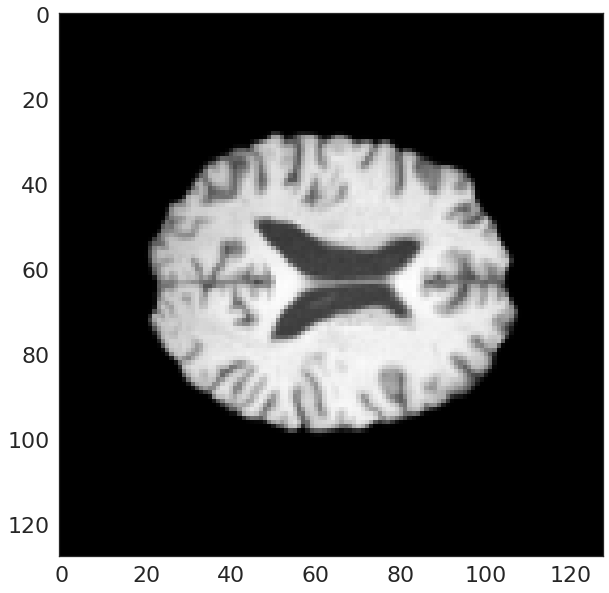

In [ ]:
plt.imshow(imgnorm(load_4D(file_names_t1[5]))[0,:,:], cmap="Greys_r")

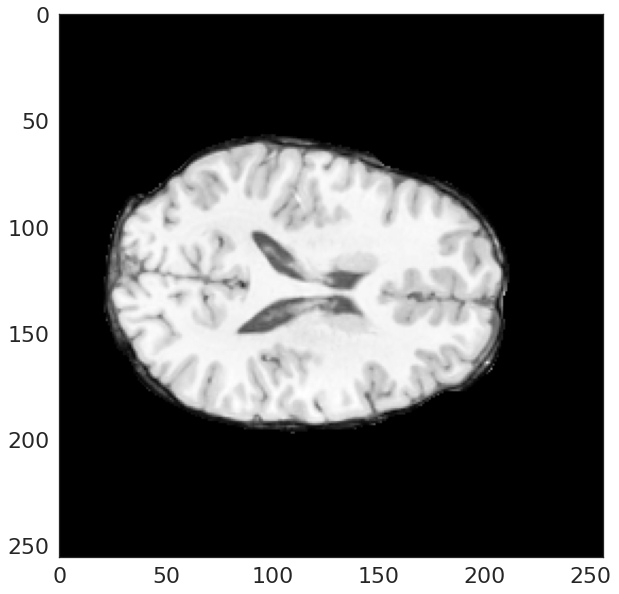

In [ ]:
plt.imshow(imgnorm(load_3D(file_names_my_t1[9]))[0,:,:], cmap="Greys_r")

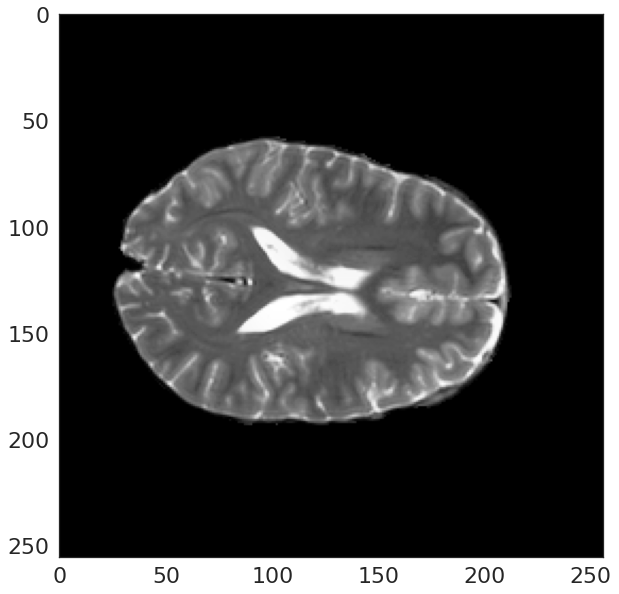

In [ ]:
plt.imshow(imgnorm(load_3D(file_names_my_t2[9]))[0,:,:], cmap="Greys_r")

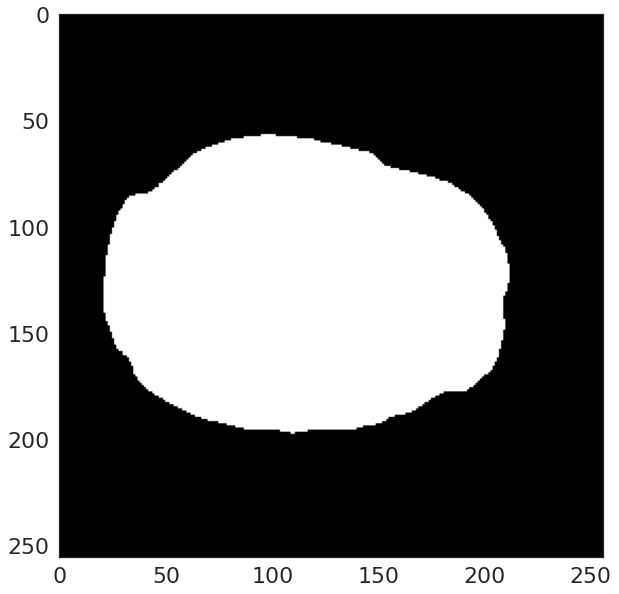

In [ ]:
plt.imshow(imgnorm(load_3D(mask_names_my_t1[9]))[0,:,:], cmap="Greys_r")

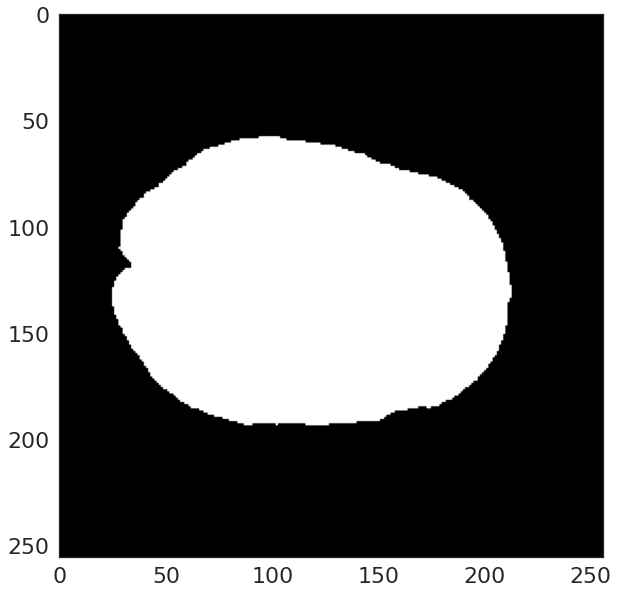

In [ ]:
plt.imshow(imgnorm(load_3D(mask_names_my_t2[9]))[0,:,:], cmap="Greys_r")

In [ ]:
mfi = mask_nifti_imgpath+"/"
ini = input_nifti_imgpath+"/"
mfi

'/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask_nifti/'

In [ ]:
!fcm-normalize -i ini -m mfi -o output_imgpath -v

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
2021-05-14 16:59:03,016 - intensity_normalization.exec.fcm_normalize - ERROR - if single-img option off, then image and brain-mask must be directories
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/intensity_normalization/exec/fcm_normalize.py", line 98, in main
    raise NormalizationError('if single-img option off, then image and brain-mask must be directories')
intensity_normalization.errors.NormalizationError: if single-img option off, then image and brain-mask must be directories


# Dataset Creation OLD - Do Not Use
* Create Pytorch dataset which reads a pair of T1,T2 images of same subject
* Performs image normalization between (0,1) and reshapes it to 128*128 standard shape
* Initialize Training and Inference dataset generator

In [ ]:
def load_4D(name, slicenum=64):
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        x_dim, y_dim, z_dim = X_np.shape

        X_np = np.array(X_np)

        #use min to remove error due to normalization
        model_np = np.full((128, 128, 128), X_np.min())
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, slicenum ]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def load_3D(name):
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        model_np = np.expand_dims(X_np, axis=0)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

def create_full_brain_mask(img_np):
  img_cp_np = np.copy(img_np)
  image_shape = img_cp_np.shape
  min_intensity = np.min(img_cp_np)
  max_intensity = np.max(img_cp_np)
  img_cp_np[img_cp_np > 0.0] = 1.0
  img_cp_np[img_cp_np <= 0.0] = 0.0
  return img_cp_np


In [ ]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, df = filtered_df, iterations =1, norm=True):
        self.df = df
        self.norm = norm
        self.iterations = iterations
        self.s0 = self.df[self.df["scanner_flag"] == 0].index.tolist()
        self.s1 = self.df[self.df["scanner_flag"] == 1].index.tolist()
        self.s2 = self.df[self.df["scanner_flag"] == 2].index.tolist()
        
  def __len__(self):
        'Denotes the total number of samples'
        # return self.df.shape[0] * self.iterations
        return 50

  def __getitem__(self, step):
        'Generates one sample of data'
        # index_pair = np.random.permutation(len(self.names)) [0:4]
        """
        fp = filtered_df["file_path"].iloc[step]
        sn = filtered_df["scanner_name"].iloc[step]
        dafl = filtered_df["dataset_flag"].iloc[step]
        agdi = filtered_df["age_disc"].iloc[step]
        """

        img1_contrast_flag = np.random.randint(3, size=1).item()
        img2_contrast_flag = (img1_contrast_flag+1)%3

        if (img1_contrast_flag == 0):
          i1_idx = np.random.choice(self.s0, 1).item()
          i2_idx = np.random.choice(self.s1, 1).item()
        elif (img1_contrast_flag == 1):
          i1_idx = np.random.choice(self.s1, 1).item()
          i2_idx = np.random.choice(self.s2, 1).item()
        else:
          i1_idx = np.random.choice(self.s2, 1).item()
          i2_idx = np.random.choice(self.s0, 1).item()

        # print(img1_contrast_flag, i1_idx, img2_contrast_flag, i2_idx)
        fp1 = self.df["file_path"].iloc[i1_idx]
        fp2 = self.df["file_path"].iloc[i2_idx]

        img1 = imgnorm(load_4D(fp1))  
        img2 = imgnorm(load_4D(fp2))   
        
        return img1, img2

In [ ]:
class IntermodalDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = A_idx
        # B_idx = randint(0, len(self.t2_filenames)-1)
        # if (A_idx == B_idx):
        #   B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        #img_A = load_4D(self.t1_filenames[idx])
        #img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        img_A = load_4D(self.t1_filenames[A_idx])
        img_B = load_4D(self.t2_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
class IntramodalDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = randint(0, len(self.t1_filenames)-1)
        # B_idx = A_idx
        B_idx = randint(0, len(self.t2_filenames)-1)
        if (A_idx == B_idx):
          B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        #img_A = load_4D(self.t1_filenames[idx])
        #img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        img_A = load_4D(self.t1_filenames[A_idx])
        img_B = load_4D(self.t2_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
class InferenceDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = idx
        # A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = A_idx
        # B_idx = randint(0, len(self.t2_filenames)-1)
        # if (A_idx == B_idx):
        #   B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        #img_A = load_4D(self.t1_filenames[idx])
        #img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])
        print(self.t1_filenames[A_idx])
        img_A = load_3D(self.t1_filenames[A_idx])
        img_B = load_3D(self.t2_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
class IntramodalInferenceDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = idx
        # A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = A_idx
        # B_idx = randint(0, len(self.t2_filenames)-1)
        # if (A_idx == B_idx):
        #   B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        img_A = load_4D(self.t1_filenames[idx])
        img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        # img_A = load_4D(self.t1_filenames[A_idx])
        # img_B = load_4D(self.t2_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
output_imgpath

'/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/output_images'

In [ ]:
#training_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=7,shuffle=True)

#training_generator = Data.DataLoader(IntermodalDataset(file_names_t1, file_names_t2, 1, True), batch_size=10,shuffle=True)
training_generator = Data.DataLoader(IntramodalDataset(file_names_t1, file_names_t1, 1, True), batch_size=10,shuffle=True)

In [ ]:
inference_generator = Data.DataLoader(InferenceDataset(file_names_output, file_names_output, 1, True), batch_size=1,shuffle=False)

In [ ]:
for  X, Y in training_generator:
  print(torch.max(X))
  print(X.shape)
  x_size = X.shape
  X_beta = X.repeat(1, 5, 1, 1)
  Y_beta = Y.repeat(1, 5, 1, 1)
  print(X_beta.shape)
  del X, Y
  break

tensor(1.)
torch.Size([10, 1, 128, 128])
torch.Size([10, 5, 128, 128])


In [ ]:
for  X, Y in inference_generator:
  print(torch.max(X))
  print(X.shape)
  del X, Y
  break

/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/output_images/IXI430-IOP-0990-T1_img_fcm.nii.gz
tensor(1.)
torch.Size([1, 1, 128, 128])


In [ ]:
np.random.randint(3, size=1).item()

2

In [ ]:
np.random.permutation(2)[0:4]

array([0, 1])

In [ ]:
img_A = imgnorm(load_4D(file_names_t1[0]))

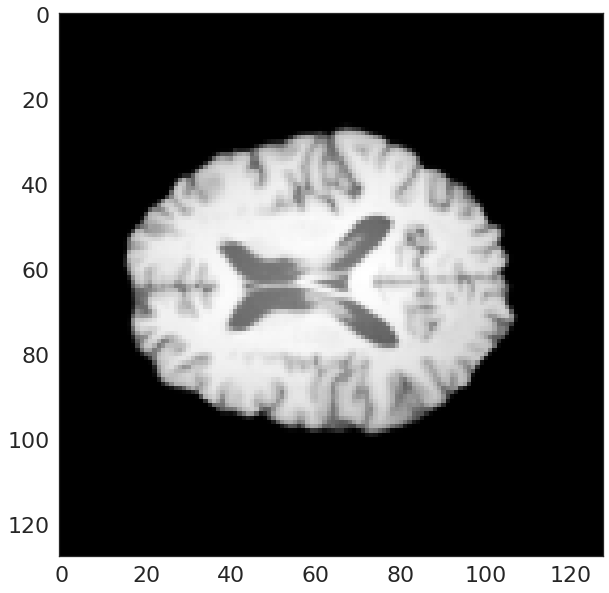

In [ ]:
plt.imshow(imgnorm(load_4D(file_names_t1[23]))[0,:,:], cmap="Greys_r")

In [ ]:
mask = create_full_brain_mask(img_A)

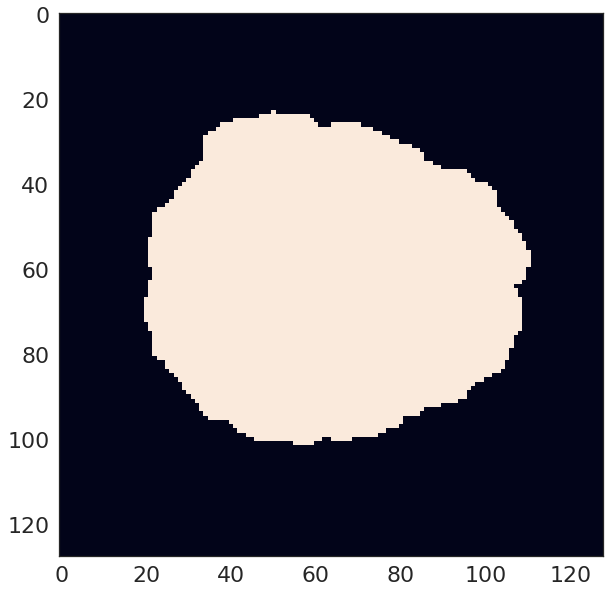

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask[0,:,:])

# Remove unwanted Files that are not registered properly to template - Do Not Use

In [ ]:
input_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/input_images"
input_nifti_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/input_nifti_images"
mask_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask"
mask_nifti_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask_nifti"
output_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/output_images"

In [ ]:
file_names_output = sorted(glob.glob(os.path.join(output_imgpath, "*.nii.gz")))

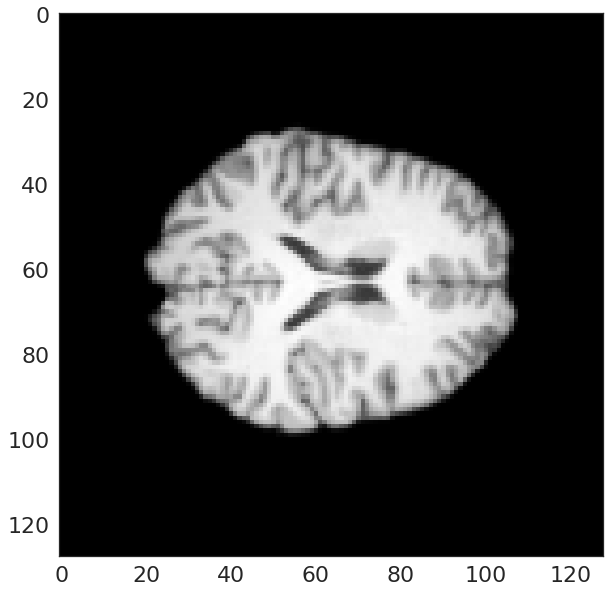

In [ ]:
o1 = load_3D(file_names_output[0])
plt.imshow(o1[0,:,:], cmap="Greys_r")

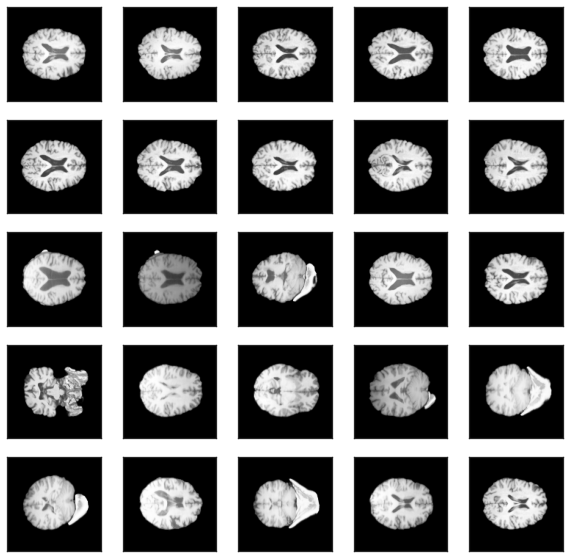

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0, 25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  o1 = load_3D(file_names_output[i+25])
  plt.imshow(o1[0,:,:], cmap="Greys_r")
plt.show()

In [ ]:
bad_images_index = [13, 16, 17, 18, 24, 37, 40,  42, 43, 44, 45, 47, 51, 53, 54, 55, 59, 66, 69, 71, 72, 78, 86, 87, 90, 97, 102, 108, 109, 110, 115, 124, 126, 129, 132, 133, 134, 138, 143, 148, 
              150, 151, 152, 153, 156, 157, 158, 160, 163, 164, 167, 175, 180, 184, 188, 195 ]

In [ ]:
good_images_index = [i for j, i in enumerate(file_names_output) if j not in bad_images_index]

In [ ]:
len(good_images_index)

144

# New Dataset fuzzy corrected - To be used for dataset creation
* Create Pytorch dataset which reads a pair of T1,T2 images of same subject
* Performs image normalization between (0,1) and reshapes it to 128*128 standard shape
* Initialize Training and Inference dataset generator

In [16]:
def load_4D(name, slicenum=64):
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        x_dim, y_dim, z_dim = X_np.shape

        X_np = np.array(X_np)

        #use min to remove error due to normalization
        model_np = np.full((128, 128, 128), X_np.min())
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, slicenum ]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def load_3D(name):
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
        model_np = np.expand_dims(X_np, axis=0)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

def create_full_brain_mask(img_np):
  img_cp_np = np.copy(img_np)
  image_shape = img_cp_np.shape
  min_intensity = np.min(img_cp_np)
  max_intensity = np.max(img_cp_np)
  img_cp_np[img_cp_np > 0.0] = 1.0
  img_cp_np[img_cp_np <= 0.0] = 0.0
  return img_cp_np

In [17]:
input_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/input_images"
input_nifti_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/input_nifti_images"
mask_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask"
mask_nifti_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/mask_nifti"
output_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/two_dim_images/output_images"

In [18]:
my_t1_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_output"
my_t2_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T2_1_output"
file_names_my_t1 = sorted(glob.glob(os.path.join(my_t1_path, "*.nii.gz")))
file_names_my_t2 = sorted(glob.glob(os.path.join(my_t2_path, "*.nii.gz")))

In [19]:
mask_nifti_t1_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T1_1_mask"
mask_nifti_t2_imgpath = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Batch_T2_1_mask"
mask_names_my_t1 = sorted(glob.glob(os.path.join(mask_nifti_t1_imgpath, "*.nii.gz")))
mask_names_my_t2 = sorted(glob.glob(os.path.join(mask_nifti_t2_imgpath, "*.nii.gz")))

In [20]:
file_names_t1[0:2]

['/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI060-Guys-0709-T1_downsampled_hm_zscore.nii.gz',
 '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/reg_IXI428-Guys-0996-T1_downsampled_hm_zscore.nii.gz']

In [21]:
# for imgpath in file_names_t1:
#   print(os.path.basename(imgpath)[4:-29])
#   basenm = os.path.basename(imgpath)[4:-29]
#   img = load_4D(imgpath)
#   img_A = imgnorm(img)
#   img_A_cp = np.copy(img_A)
#   mask = create_full_brain_mask(img_A_cp)
  
#   np.save(two_d_imgpath + "/" + basenm +"_img", arr=img_A )
#   np.save(mask_imgpath + "/" + basenm + "_mask", arr=mask )
#   nb.save(nb.Nifti1Image(img_A[0,:,:], np.eye(4)) , input_nifti_imgpath + "/" + basenm  + '_img.nii.gz')
#   nb.save(nb.Nifti1Image(mask[0,:,:], np.eye(4)) , mask_nifti_imgpath + "/" + basenm  + '_mask.nii.gz')

In [22]:
# mask = np.load(mask_imgpath+"/IXI438-HH-2155-T1_mask.npy")

In [23]:
# plt.imshow(mask[0,:,:])

In [24]:
# mfi = mask_nifti_imgpath+"/"
# ini = input_nifti_imgpath+"/"
# mfi

FCM Doesn't run in colab
* Downoad two dim images folder to local
* Run FCM mask generation in local
* Upload the mask and output folder bakc
* sudo python /Users/surajshashidhar/anaconda3/envs/image_registration/lib/python3.7/site-packages/intensity_normalization/exec/fcm_normalize.py -i "/Users/surajshashidhar/Downloads/two_dim_images/input_nifti_images" -m "/Users/surajshashidhar/Downloads/two_dim_images/mask_nifti" -o "/Users/surajshashidhar/Downloads/two_dim_images/output_images" -v

In [25]:
# !fcm-normalize -i ini -m mfi -o output_imgpath -v

In [26]:
# os.path.isdir(ini) 

In [27]:
# file_names_output = sorted(glob.glob(os.path.join(output_imgpath, "*.nii.gz")))

In [28]:
# bad_images_index = [13, 16, 17, 18, 24, 37, 40,  42, 43, 44, 45, 47, 51, 53, 54, 55, 59, 66, 69, 71, 72, 78, 86, 87, 90, 97, 102, 108, 109, 110, 115, 124, 126, 129, 132, 133, 134, 138, 143, 148, 
#               150, 151, 152, 153, 156, 157, 158, 160, 163, 164, 167, 175, 180, 184, 188, 195 ]

In [29]:
# good_images_index = [i for j, i in enumerate(file_names_output) if j not in bad_images_index]

In [20]:
class IntramodalDatasetwithPreprocess(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.t1_masknames = mask_names_my_t1
        self.t2_masknames = mask_names_my_t2
        self.norm = False
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = A_idx
        # B_idx = randint(0, len(self.t2_filenames)-1)
        # if (A_idx == B_idx):
        #   B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        img_A = load_3D(self.t1_filenames[A_idx])
        mask_A = load_3D(self.t1_masknames[A_idx])
        # img_B = load_3D(self.t1_filenames[(A_idx + 4) % len(self.t1_filenames)])
        img_B = load_3D(self.t2_filenames[B_idx])
        mask_B = load_3D(self.t2_masknames[B_idx])
        return img_A, img_B, mask_A, mask_B

In [21]:
o1 = load_3D(file_names_my_t1[4])
o2 = load_3D(file_names_my_t2[4])

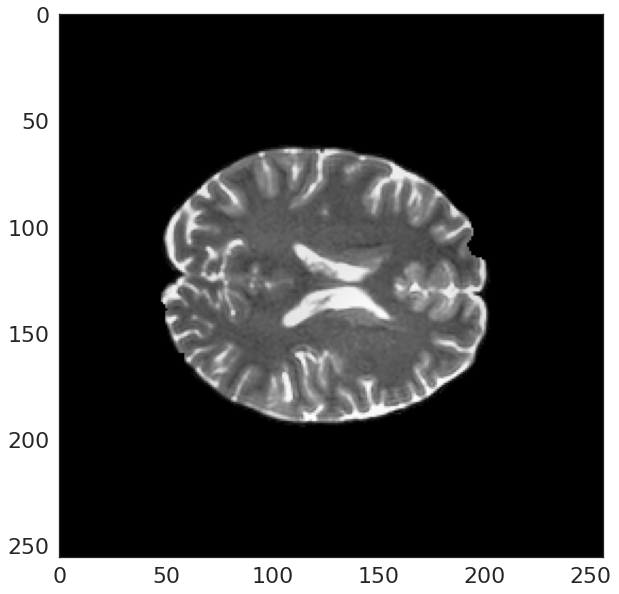

In [32]:
plt.imshow(o2[0, :, :], cmap="Greys_r")

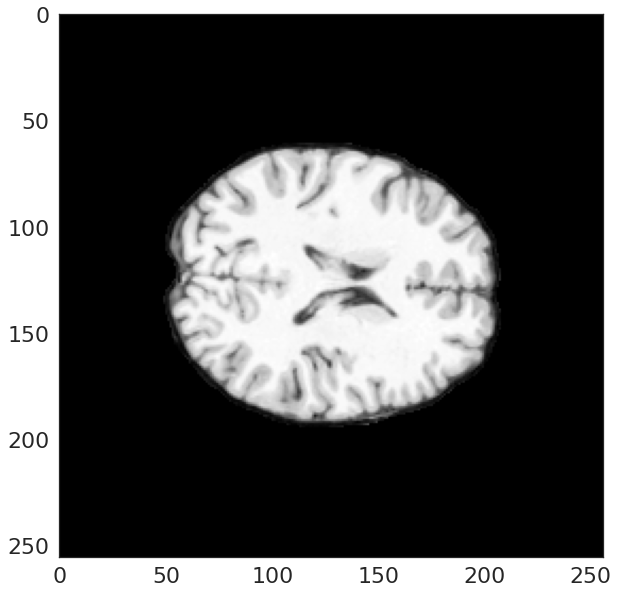

In [33]:
plt.imshow(o1[0, :, :], cmap="Greys_r")

In [22]:
training_generator = Data.DataLoader(IntramodalDatasetwithPreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=5,shuffle=True, drop_last=True)

In [35]:
for X, Y, P, Q in training_generator:
  print(X.shape)
  print(P.shape)
  print( torch.min(X[0,:,:]), torch.max(X[0,:,:]), torch.mean(X) )
  break

torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
tensor(0.) tensor(1.) tensor(0.1937)


In [36]:
# d=5
# print( torch.min(X[d,0,:,:]), torch.max(X[d,0,:,:]) )
# plt.imshow(X[d,0,:,:], cmap="Greys_r")

In [23]:
class IntramodalInferenceDatasetwthpreprocess(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.t1_masknames = mask_names_my_t1
        self.t2_masknames = mask_names_my_t2
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = idx
        B_idx = A_idx

        img_A = load_3D(self.t1_filenames[A_idx])
        img_B = load_3D(self.t2_filenames[B_idx])
        mask_A = load_3D(self.t1_masknames[A_idx])
        mask_B = load_3D(self.t2_masknames[B_idx])
                       
        return img_A, img_B, mask_A, mask_B

In [38]:
import scipy.stats

In [24]:
inference_generator = Data.DataLoader(IntramodalInferenceDatasetwthpreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=1,shuffle=True, drop_last=True)

In [25]:
for X, Y, P, Q in inference_generator:
  print(X.shape)
  print(torch.max(X), torch.min(X))
  print(torch.max(Y), torch.min(Y))
  x_hist = torch.histc(X, bins=20, min=0, max=1).numpy()
  y_hist = torch.histc(Y, bins=20, min=0, max=1).numpy()
  print(scipy.stats.chisquare(f_obs=x_hist, f_exp=y_hist,ddof=0))
  print(scipy.stats.chisquare(f_obs=x_hist, f_exp=x_hist,ddof=0)[0])
  print("------------ --------------- ---------------")
  print(torch.histc(X, bins=20, min=0, max=1).numpy())
  print(torch.histc(Y, bins=20, min=0, max=1).numpy())
  print("------------ --------------- ---------------")
  print()
  hist,bins = np.histogram(X[0,:, :].ravel(),256,[0,1])
  print(hist)
  print(bins)
  print("------------ --------------- ---------------")
  print()
  hist,bins = np.histogram(Y[0,:, :].ravel(),256,[0,1])
  print(hist)
  print(bins)
  break

torch.Size([1, 1, 256, 256])
tensor(1.) tensor(0.)
tensor(1.) tensor(0.)
Power_divergenceResult(statistic=67880.54, pvalue=0.0)
0.0
------------ --------------- ---------------
[45394.   214.   276.  1228.  1366.   655.   609.   651.   469.   710.
   637.   573.  1018.  1095.  1184.  1242.  1243.  2042.  4162.   768.]
[46138.   129.    92.    88.    96.   377.  2063.  3274.  3113.  1551.
  1132.   760.   572.   516.   440.   430.   741.  2770.   524.   730.]
------------ --------------- ---------------

[45244     0    17     0    57     0    34     0     0    25     0    17
     0    31     0    33     0     0    34     0    39     0    44     0
    33     0     0    36     0    46     0    40     0   100     0     0
    54     0    94     0    97     0     0   159     0   236     0   298
     0   344     0     0   353     0   400     0   193     0   173     0
     0   132     0   115     0   185     0   134     0     0   120     0
   105     0   111     0     0    89     0    94     

In [ ]:
torch.Tensor([1e-8])
torch.add(x_hist[0] ,torch.Tensor([1e-8]))
x_hist[0]

#torch.square(torch.subtract(x_hist[0], y_hist[0]))

In [ ]:
x_hist = torch.histc(X, bins=20, min=0, max=1)
y_hist = torch.histc(Y, bins=20, min=0, max=1)
histogram_loss = torch.zeros(size=(20,))
for i in range(x_hist.shape[0]):
  histogram_loss[i] = torch.square( (x_hist[i]-y_hist[i]) / torch.add(y_hist[i], torch.Tensor([1e-12])) ) 


In [ ]:
histogram_loss

In [ ]:
torch.sum(histogram_loss)

# Model Creation

* Create simple Unet 
* Two Unets one each for encoder and decoder. The same unet is shared between two encoders and another Unet is shared between 4 decoders.
* Encoder side Unet takes in images and produces 16 channel output
* Beta head that would take 16 channel output from encoder unet and produces 5 channels of brain anatomy
* Theta head that takes 16 channel input from encoder unet and produces a single vector of one or two dimension max of real number
* Randomization head which mixes up channels of betas with uniform random.
* Decoder Unet takes in Betas and Theta concatenated and produces 16 output maps. There are 4 decoders hence 4 combinations of Beta and theta are passed through same decoder Unet 4 times.
* Reconstrunction head that takes the 16 channel output of decoder Unet and produces output image. The output image is dependent on Theta that inturn dependent on contrast, protocol, etc on image. T1 and T2 will have different Theta. Since we have 4 decoders we repeat this 4 times usong same reconstruction head

Credit for Unet model: https://github.com/milesial

In [26]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            
            nn.ReLU(),
            nn.BatchNorm2d(mid_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=2),
            
            nn.ReLU(),
            nn.BatchNorm2d(in_channels),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.Sequential(nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2), 
                                    
                                    nn.ReLU(),
                                    nn.BatchNorm2d(in_channels // 2))
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv =  nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                                   
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_channels))
    def forward(self, x):
        return self.conv(x)

       
class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv =  nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                                                       
                                   nn.Sigmoid(),
                                   nn.BatchNorm2d(out_channels))
    def forward(self, x):
        return self.conv(x)

In [27]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc1 = InConv(n_channels, 8)
        self.inc2 = DoubleConv(8, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down6 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64 // factor, bilinear)
        self.up5 = Up(64, 32 // factor, bilinear)
        self.up6 = Up(32, 16, bilinear)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        x1 = self.inc1(x)
        x1 = self.inc2(x1)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        # print(x5.shape, x6.shape, x7.shape)
        x = self.up1(x7, x6)
        x = self.up2(x, x5)
        x = self.up3(x, x4)
        x = self.up4(x, x3)
        x = self.up5(x, x2)
        x = self.up6(x, x1)
        logits = self.outc(x)
        return logits

In [28]:
class ConvHead(nn.Module):

  def __init__(self, input_channel=16, output_channel=1):
    super(ConvHead, self).__init__()
    self.convlayer = self.convblock(input_channel, output_channel)

  
  def convblock(self, in_channel, out_channel):
    convlayer = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
                             nn.BatchNorm2d(out_channel),
                             nn.Sigmoid())
    return convlayer
  

  def downsampler(self, in_channel, out_channel):
    downlayer = nn.Sequential(nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(out_channel),
            nn.ReLU())
    return downlayer
  
  
  def downblock(self, downlayer, convlayer, activation_maps):
    # z = downlayer(activation_maps)
    z = convlayer(z)
    return z

  def forward(self, x):
    z = self.convlayer(x)
    return z


In [29]:
class BetaHead(nn.Module):
  def __init__(self,in_channel, Cb=7, Ct=2):
        self.in_channel = in_channel
        self.Cb = Cb
        self.Ct = Ct

        super(BetaHead, self).__init__()
        self.probmaps = self.probability_map(self.in_channel, self.Cb * 1)
        self.softmax_output = nn.Softmax(dim=1)

  def probability_map(self, in_channel, Cb, ks=3, st=1, pd=1, bi=False):
    layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels = self.Cb, kernel_size=ks, stride=st, padding=pd, bias=bi),
                nn.BatchNorm2d(self.Cb),           
                nn.Sigmoid())
    return layer

  def forward(self, x, hard_flag=True, tau=1.0):  
        pmap = self.probmaps(x)
        ohe = nn.functional.gumbel_softmax(pmap, tau=tau, hard=hard_flag, dim=1)
        smax = self.softmax_output(pmap)
        return pmap, ohe, smax

In [30]:
class ThetaHead(nn.Module):
  def __init__(self,in_channel, Ct=1):
        self.in_channel = in_channel
        self.Ct = Ct

        super(ThetaHead, self).__init__()
        self.td = self.theta_head(self.in_channel)

  def theta_head(self, in_channel):
    layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels = 32, kernel_size=64, stride=8, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.Flatten(),
                nn.Linear(20000, self.Ct))
    return layer

  def forward(self, x):  
        theta_op = self.td(x)
        return theta_op

In [31]:
class RandomizationHead(nn.Module):
  def __init__(self, Cb=7, Ct=1, randomize_flag=True):
        self.Cb = Cb
        self.Ct = Ct
        self.randomize_flag = randomize_flag
        self.img_dim = 256
        super(RandomizationHead, self).__init__()
        self.feature_map_selection_lst_recon1 = self.randomize_betas()
        self.feature_map_selection_lst_recon2 = self.randomize_betas()
        self.feature_map_selection_lst_recon3 = self.randomize_betas()
        self.feature_map_selection_lst_recon4 = self.randomize_betas()
        print("beta_selection1: {}".format(self.feature_map_selection_lst_recon1 ))
        print("beta_selection2: {}".format(self.feature_map_selection_lst_recon2 ))
        print("beta_selection3: {}".format(self.feature_map_selection_lst_recon3 ))
        print("beta_selection4: {}".format(self.feature_map_selection_lst_recon4 ))

  def randomize_betas(self):

        """ 
        - There are two betas each from image 1 and image 2 = B1, B2
        - In each B1 and B2 there are 5 channels of (128*128) same size as input image
        - For each Beta channel do a coin toss(if there are 5 channels then 5 coin tosses)
        - For each channel either pick the channel information from B1 or B2 with equal probability
        - We have a total of 5 channels from B1 and 5 channels from B2 concatenated to 10 channels tensor
        - [0,1,2,3,4] = B1; [5,6,7,8,9] = B2 ===> concatenated_Beta=[0,1,2,3,4,   5,6,7,8,9]
        - For channel1 pick between (0,5), channel2 pick between (1,6), channel3 pick between(2,7), channel4 pick between(3,8), channel5 pick between(4, 9) with equal probability
        - So there are 2^5 = 32 possible combinations=> Same is mentioned in youtube video

        """

        rnd_lst = np.random.choice(2, self.Cb, p=[0.5, 0.5]).tolist()

        for i in range(len(rnd_lst)):
          ln = len(rnd_lst) - 1
          if (rnd_lst[i] == 0):
            rnd_lst[i] = rnd_lst[i] + i
          else:
            rnd_lst[i] = rnd_lst[i] + ln + i  
          
        return rnd_lst

  def forward(self, beta1, beta2, theta1, theta2): 

    if (self.randomize_flag):

      # Get 4 randomized maps selection for 4 decoder instances

      self.feature_map_selection_lst_recon1 = self.randomize_betas()
      self.feature_map_selection_lst_recon2 = self.randomize_betas()
      self.feature_map_selection_lst_recon3 = self.randomize_betas()
      self.feature_map_selection_lst_recon4 = self.randomize_betas()
      # print(self.feature_map_selection_lst_recon1, self.feature_map_selection_lst_recon2, self.feature_map_selection_lst_recon3, self.feature_map_selection_lst_recon4)
      
      # Reconstruct theta to match the dimensionality of beta to 128*128
      batch_size = beta1.shape[0] 
      theta1_reconstructed = theta1.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)
      theta2_reconstructed = theta2.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)


      # Use the randomized map selection to select  channels from both betas
      beta = torch.cat((beta1, beta2), dim=1)

      beta_recon1 = beta[:,self.feature_map_selection_lst_recon1, :, : ]
      beta_recon2 = beta[:,self.feature_map_selection_lst_recon2, :, : ]
      beta_recon3 = beta[:,self.feature_map_selection_lst_recon3, :, : ]
      beta_recon4 = beta[:,self.feature_map_selection_lst_recon4, :, : ]

      # Combine spatially reconstructed theta and randomized beta feature maps

      input_recon1 = torch.cat((beta_recon1, theta1_reconstructed), 1)
      input_recon2 = torch.cat((beta_recon2, theta2_reconstructed), 1)
      input_recon3 = torch.cat((beta_recon3, theta1_reconstructed), 1)
      input_recon4 = torch.cat((beta_recon4, theta2_reconstructed), 1)
    
    else:
      # Reconstruct theta to match the dimensionality of beta to 128*128
      batch_size = beta1.shape[0] 
      theta1_reconstructed = theta1.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)
      theta2_reconstructed = theta2.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)

      input_recon1 = torch.cat((beta1, theta1_reconstructed), 1)
      input_recon2 = torch.cat((beta2, theta2_reconstructed), 1)
      input_recon3 = torch.cat((beta1, theta1_reconstructed), 1)
      input_recon4 = torch.cat((beta2, theta2_reconstructed), 1)

    return input_recon1, input_recon2, input_recon3, input_recon4

In [32]:
class RandomizationHeadnew(nn.Module):
  def __init__(self, Cb=7, Ct=1):
        self.Cb = Cb
        self.Ct = Ct
        self.img_dim = 256
        super(RandomizationHeadnew, self).__init__()

  def forward(self, beta1, beta2, theta1, theta2): 
      
      # Reconstruct theta to match the dimensionality of beta to 128*128
      batch_size = beta1.shape[0] 
      theta1_reconstructed = theta1.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)
      theta2_reconstructed = theta2.repeat(1, self.img_dim, self.img_dim).reshape(batch_size, self.Ct, self.img_dim, self.img_dim)

      input_recon1 = torch.cat((beta1, theta1_reconstructed), 1)
      input_recon2 = torch.cat((beta2, theta2_reconstructed), 1)
      input_recon3 = torch.cat((beta1, theta1_reconstructed), 1)
      input_recon4 = torch.cat((beta2, theta2_reconstructed), 1)

      return input_recon1, input_recon2, input_recon3, input_recon4

In [33]:
class ReconstructionHead(nn.Module):
  def __init__(self,in_channel, Cb=7, Ct=2):
        self.in_channel = in_channel
        self.Cb = Cb
        self.Ct = Ct
        super(ReconstructionHead, self).__init__()
        self.reconstruction_head = self.reconstruct()

  def reconstruct(self):
    layer = nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=1, stride=1, padding=1, kernel_size=3, bias=False ), 
                          nn.BatchNorm2d(1),
                          nn.Sigmoid())
    return layer

  def forward(self, input_recon): 
      batch_size = input_recon.shape[0] 
      #theta_reconstructed = theta.repeat(1, 128, 128).reshape(batch_size, self.Ct, 128, 128)
      #x_in = torch.cat((beta, theta_reconstructed), 1)
      rh = self.reconstruction_head(input_recon)
      return rh

In [34]:
pmap = torch.ones(size = (10,5,128,128))
o_p = nn.functional.gumbel_softmax(pmap, tau=1, hard=False, dim=1)
m = nn.Softmax(dim=1)
o_s = m(pmap)
o_p.shape

torch.Size([10, 5, 128, 128])

In [35]:
print( torch.min(o_p[0, 0, :, :]), torch.max(o_p[0, 0, :, :]) )
print( torch.min(o_p[0, 1, :, :]), torch.max(o_p[0, 1, :, :]) )
print( torch.min(o_p[0, 2, :, :]), torch.max(o_p[0, 2, :, :]) )
print( torch.min(o_p[0, 3, :, :]), torch.max(o_p[0, 3, :, :]) )
print( torch.min(o_p[0, 4, :, :]), torch.max(o_p[0, 4, :, :]) )

tensor(2.0987e-05) tensor(0.9993)
tensor(3.3598e-05) tensor(0.9999)
tensor(7.7504e-06) tensor(0.9997)
tensor(5.5674e-06) tensor(0.9998)
tensor(6.6552e-06) tensor(0.9997)


In [36]:
print( torch.min(o_s[0, 0, :, :]), torch.max(o_s[0, 0, :, :]) )
print( torch.min(o_s[0, 1, :, :]), torch.max(o_s[0, 1, :, :]) )
print( torch.min(o_s[0, 2, :, :]), torch.max(o_s[0, 2, :, :]) )
print( torch.min(o_s[0, 3, :, :]), torch.max(o_s[0, 3, :, :]) )
print( torch.min(o_s[0, 4, :, :]), torch.max(o_s[0, 4, :, :]) )

tensor(0.2000) tensor(0.2000)
tensor(0.2000) tensor(0.2000)
tensor(0.2000) tensor(0.2000)
tensor(0.2000) tensor(0.2000)
tensor(0.2000) tensor(0.2000)


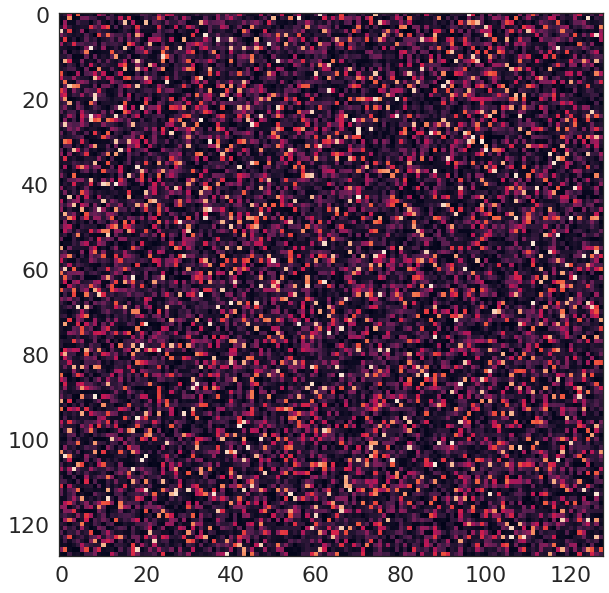

In [37]:
plt.imshow(o_p[0,0,:,:])

In [38]:
input = torch.randn(size=(2, 1, 128, 128))
input1 = torch.randn(size=(2, 3, 128, 128))
input_t1 = torch.randn(size=(2, 1, 256, 256))
input_t2 = torch.randn(size=(2, 1, 256, 256))
encoder = UNet(1, 16)
beta = BetaHead(in_channel = 16, Cb=5, Ct=1)
theta = ThetaHead(16, 1)
encoder_unet_model = UNet(1, 16, bilinear=False)
decoder_unet_model = UNet(6, 16, bilinear=False)
recon = ReconstructionHead(16, 5, 1)
rndh = RandomizationHead(Cb=5, Ct=1)

beta_selection1: [5, 1, 2, 8, 9]
beta_selection2: [5, 6, 7, 3, 9]
beta_selection3: [5, 6, 2, 8, 9]
beta_selection4: [5, 6, 2, 3, 9]


In [39]:
u1 = encoder_unet_model(input_t1)
p1, o1,s1 = beta(u1)
t1  = theta(u1)

In [40]:
u1 = encoder_unet_model(input_t1)
p1, o1, s1 = beta(u1)
p1t, o1t, s1t = beta(u1, hard_flag=True)
t1  = theta(u1)

#r1 = recon(o1, t1)

In [41]:
p1, o1 = beta(u1)
p1t, o1t = beta(u1, hard_flag=True)

ValueError: ignored

In [66]:
for i in range(5):
  p5, o5, s5 = beta(u1, hard_flag=False, tau=0.5)
  p1, o1, s1 = beta(u1, hard_flag=False, tau=1.0)
  p1t, o1t, s1t = beta(u1, hard_flag=True)
  g1 = calc_concrete_dist(p1)
  gst = calc_concrete_dist(p1, ST=True)
  print(p1[0, :, 0, 0])
  print(o1[0, :, 0, 0])
  print(s1[0, :, 0, 0])
  print(g1[0, :, 0, 0])
  print(gst[0, :, 0, 0])
  print()
  print(p5[0, :, 0, 0])
  print(o5[0, :, 0, 0])
  print(s5[0, :, 0, 0])
  print()
  print(p1t[0, :, 0, 0])
  print(o1t[0, :, 0, 0])
  print(s1t[0, :, 0, 0])
  print(" ================ =================== ===================")
  print()
  i = i+1

TypeError: ignored

In [ ]:
u2 = encoder_unet_model(input_t2)
p2, o2 = beta(u2)
t2  = theta(u2)
#r2 = recon(o2, t2)

In [ ]:
plt.imshow(p2[0,1,:,:].detach().numpy(), cmap="Greys_r")

In [ ]:
input_recon1, input_recon2, input_recon3, input_recon4 = rndh(o1, o2, t1, t2)

In [ ]:
d1 = decoder_unet_model(input_recon1)
d2 = decoder_unet_model(input_recon2)
d3 = decoder_unet_model(input_recon3)
d4 = decoder_unet_model(input_recon4)

In [ ]:
r1 = recon(d1)
r2 = recon(d2)
r3 = recon(d3)
r4 = recon(d4)

Model tested

In [ ]:
x = torch.randn(size=(7,2))
y = x.repeat(1, 128, 128).reshape(7, 2, 128, 128)

In [ ]:
rnd_lst = np.random.choice(2, 5, p=[0.5, 0.5]).tolist()
print(rnd_lst)
for i in range(len(rnd_lst)):
  ln = len(rnd_lst) - 1
  if (rnd_lst[i] == 0):
    rnd_lst[i] = rnd_lst[i] + i
  else:
    rnd_lst[i] = rnd_lst[i] + ln + i  
  
print(rnd_lst)

In [ ]:
sample_beta = torch.randn(size=(4, 5, 128, 128))
sgmd = nn.Sigmoid()
sample_beta = sgmd(sample_beta)

In [ ]:
plt.imshow(sample_beta[0,0,:,:], cmap="Greys_r")

In [ ]:
gsop = nn.functional.gumbel_softmax(sample_beta, tau=2.0, hard=False, dim=1)

In [ ]:
plt.imshow(gsop[0,0,:,:], cmap="Greys_r")

In [65]:
class StraightThrough(torch.autograd.Function):
    ''' Straight Through Layer, threshold at .5 in the forward pass
        copy the gradient in the backward pass'''
    @staticmethod
    def forward(ctx, input):
        print(input)
        ctx.save_for_backward(input)
        # print(input)
        # return (input>0.5).type(torch.float32)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input

ST = StraightThrough.apply

def calc_concrete_dist(p, ST=False):
    '''Concrete distribution in the binary case'''
    EPS = 1e-10
    u = torch.rand(p.shape).to(p.device)
    y = 1/(1+torch.exp(
        -torch.log(u+EPS) + torch.log(1-u+EPS)
        -torch.log(p+EPS) + torch.log(1-p+EPS)))
    if ST:
      # print(Y)
      # print(torch.dtype(y))
      y = ST(p)
    return y


In [56]:
g1 = calc_concrete_dist(p1)

In [67]:
calc_concrete_dist(p1, ST=True)

TypeError: ignored

# Miscellaneous - dont use it/ run it

Trying to load pretrained weights of brain segmentation to unets, this could result in better training. But was not possible due to mismatches in shape

In [ ]:
pretrained_unetmodel = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [ ]:
model_layers_lst = list(pretrained_unetmodel.children())

In [ ]:
model_layers_lst

[Sequential(
   (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (enc1relu1): ReLU(inplace=True)
   (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (enc1relu2): ReLU(inplace=True)
 ),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Sequential(
   (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (enc2relu1): ReLU(inplace=True)
   (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (enc2relu2): ReLU(inplace=

In [ ]:
features = nn.ModuleList(pretrained_unetmodel.children())[4:-14]
unetencoder = torch.nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1) , *(list(pretrained_unetmodel.children())[2:7]))
bb = nn.Sequential(nn.Conv2d(1, 3, 3, 1, 1), *(list(pretrained_unetmodel.children())[0:9]))
cc = nn.Sequential(*(list(pretrained_unetmodel.children())[9:-1]))
dd = nn.Sequential(*(list(pretrained_unetmodel.children())))

In [ ]:
print(bb)

In [ ]:
print(cc)

In [ ]:
op1 = bb(input)
print(op1.shape)
op2 = cc(op1)

In [ ]:
op3 = dd(input1)

# Loss Functions and Miscellaneous

* Trying out different loss functions and initializating them
* Cosine, MSE, Cross corelation

In [60]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [61]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [ ]:
class StraightThrough(torch.autograd.Function):
    ''' Straight Through Layer, threshold at .5 in the forward pass
        copy the gradient in the backward pass'''
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input>0.5).type(torch.float32)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input

ST = StraightThrough.apply

def calc_concrete_dist(p, ST=False):
    '''Concrete distribution in the binary case'''
    EPS = 1e-10
    u = torch.rand(p.shape).to(p.device)
    y = 1/(1+torch.exp(
        -torch.log(u+EPS) + torch.log(1-u+EPS)
        -torch.log(p+EPS) + torch.log(1-p+EPS)))
    if ST:
        y = ST(y)
    return y

In [62]:
o1 = torch.from_numpy(np.full(shape=(2,5,128,128), fill_value=-2.0))
o2 = torch.from_numpy(np.full(shape=(2,5,128,128), fill_value=1.0))
o3 = torch.from_numpy(np.full(shape=(2,5,128,128), fill_value=0.0))

In [63]:
cosine_similarity = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
similarity_loss = cosine_similarity(o1.view(2,5,-1), o2.view(2,5,-1))
similarity_loss.mean(dim=1)

tensor([-1., -1.], dtype=torch.float64)

In [64]:
input1 = torch.randn(3,5,128, 128)
input2 = torch.randn(3,5,128, 128)

input3 = torch.tensor([[1. , 1.], [0.1, 1.]])
input4 = torch.tensor([[1. , -1.], [0., 1.]])

cos = nn.CosineSimilarity(dim=2, eps=1e-6)
cos1 = nn.CosineSimilarity(dim=1, eps=1e-6)

output = cos(input1.view(3,5,-1), input2.view(3,5,-1))
output1 = cos1(input3, input4)

print(output.size(), output1.size())
print(output, output1)
print(output.mean(), output1.mean())

torch.Size([3, 5]) torch.Size([2])
tensor([[-1.0347e-02, -6.5157e-03, -7.1013e-03,  3.1898e-03,  1.1269e-02],
        [-1.4376e-03, -7.8530e-03, -1.1921e-02,  1.8650e-03,  8.1697e-04],
        [ 4.5452e-03,  7.1977e-05,  1.4938e-02, -3.6292e-03, -9.8849e-04]]) tensor([0.0000, 0.9950])
tensor(-0.0009) tensor(0.4975)


In [65]:
loss = nn.MSELoss()
input = torch.abs(torch.randn(3, 1, 128, 128, requires_grad=False))
target = torch.abs(torch.randn(3, 1, 128, 128))
output = loss(input, target)
print(output)

tensor(0.7193)


In [66]:
ces = torch.nn.CosineEmbeddingLoss()
ces(input3, input4, torch.ones(size=(2, 2)))

tensor(0.5025)

# Training

* Train the model for 200 epochs at hyperparameters mentioned in the paper
* Although different combinations of hyperparameters and loss function weighting would be tested

In [ ]:

myx = torch.from_numpy(np.full(shape=(10,5,128,128),fill_value=-1.0  ) )
myy = torch.from_numpy(np.full(shape=(10,5,128,128),fill_value= 1.0  ) )
myz = torch.from_numpy(np.full(shape=(10,5,128,128),fill_value= 0.0  ) )
similarity_loss = torch.nn.CosineSimilarity(dim=2, eps=1e-06)
myx.view(10, 5, -1).shape
#o_x.view(10, 5, -1), o_y.view(10, 5, -1)

torch.Size([10, 5, 16384])

In [ ]:
print(1.0-similarity_loss(myx.view(10, 5, -1), myy.view(10, 5, -1)))
print(similarity_loss(myz.view(10, 5, -1), myy.view(10, 5, -1)).shape)
print(1.0 - similarity_loss(myx.view(10, 5, -1), myz.view(10, 5, -1)))
print(1.0 - similarity_loss(myx.view(10, 5, -1), myx.view(10, 5, -1)))

tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]], dtype=torch.float64)
torch.Size([10, 5])
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)


In [ ]:
del encoder_unet_model, decoder_unet_model, betahead, thetahead, randomizehead, reconstructionhead
torch.cuda.empty_cache()

In [ ]:
encoder_unet_model = UNet(1, 16, bilinear=False).to("cuda")
betahead = BetaHead(16, Cb=5, Ct=1).to("cuda")
thetahead = ThetaHead(16, Ct=1).to("cuda")

# betacomparehead = ReconstructionHead(5, 5, 1).to("cuda")
randomizehead = RandomizationHead(Cb=5, Ct=1).to("cuda")

decoder_unet_model = UNet(6, 16, bilinear=False).to("cuda")
reconstructionhead = ReconstructionHead(16, 5, 1).to("cuda")


beta_selection1: [5, 6, 7, 8, 4]
beta_selection2: [5, 6, 2, 3, 9]
beta_selection3: [0, 6, 2, 3, 4]
beta_selection4: [0, 6, 7, 8, 9]


In [ ]:
wandb.config = dict(
    epochs=201,    
    batch_size=5,
    learning_rate=0.001,
    hyperparam1=1.0,
    hyperparam2=1.0,
    lmda=0.00025,
    dataset="MRI-IXI-T1,T2",
    architecture="UNET-CNN")

config = wandb.config

In [ ]:
hyperparam1 = config["hyperparam1"]

# We need to increase cosine similarity hence multiply by negative sign. In tensorflow the cosine loss comes prebuilt with -1 multiplied, In pytorch it is not
hyperparam2 = config["hyperparam2"]
lmbda = config["lmda"]
lr=config["learning_rate"]

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space/latent_space_harmonization_v14_200.pth')

encoder_unet_model.load_state_dict(checkpoint['encoder_unet_model'])
decoder_unet_model.load_state_dict(checkpoint['decoder_unet_model'])
betahead.load_state_dict(checkpoint['betahead'])
thetahead.load_state_dict(checkpoint['thetahead'])
reconstructionhead.load_state_dict(checkpoint["reconstructionhead"])

<All keys matched successfully>

In [ ]:
crosscorr_loss = NormalizedCrossCorrelation().to("cuda")
reconstruction_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
similarity_loss = torch.nn.CosineSimilarity(dim=2, eps=1e-06)
# similarity_loss = torch.nn.CosineEmbeddingLoss()
#ces(input3, input4, torch.ones(size=(2, 2))
hyperparam1 = config["hyperparam1"]

# We need to increase cosine similarity hence multiply by negative sign. In tensorflow the cosine loss comes prebuilt with -1 multiplied, In pytorch it is not
hyperparam2 = config["hyperparam2"]
lmbda = config["lmda"]
lr=config["learning_rate"]

In [ ]:
o1 = torch.tensor([[[1., -1., 0., 2.0], [1., 0., -1., -2.0], [-1., 0., 1., 3.0]], [[1., -1., 0., 2.0], [1., 0., -1., -2.0], [-1., 0., 1., 3.0]]])
o2 = torch.tensor([[[1., -1., 0., -2.0], [1., 0., -1., 3.0], [-1., 0., 1., 4.0]], [[1., -1., 0., 2.0], [1., 0., -1., -2.0], [1., 0., -1., -3.0]]])
print(o1.shape)
o1.view(3, -1).shape
print(similarity_loss(o1, o2))
similarity_loss(o1, o2).mean()

torch.Size([2, 3, 4])
tensor([[-0.3333, -0.4924,  0.9949],
        [ 1.0000,  1.0000, -1.0000]])


tensor(0.1949)

In [ ]:
# mae_loss(o1, o2)
histogram_loss = torch.zeros(size=(1,))
histogram_loss

tensor([0.])

In [ ]:
optimizer = torch.optim.Adam( list( encoder_unet_model.parameters())   + list( betahead.parameters() ) + list(thetahead.parameters())  + 
                              list( decoder_unet_model.parameters()) + list( reconstructionhead.parameters()) + list(randomizehead.parameters()) , lr=lr ) 
#+ list(randomizehead.parameters()) + list( decoder_unet_model.parameters()) + list(betacomparehead.parameters())  + list(betacomparehead.parameters())
model_dir = '/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  reconstruction_loss_lst = []
  similarity_loss_lst = []
  total_loss_lst = []
  cosine_similarity_loss_lst = []
  histogram_similarity_loss_lst = []
  mask_x_loss_lst = []
  mask_y_loss_lst = []
  tones = torch.ones(size=(256, 256)).to("cuda")
  teps = torch.Tensor([1e-12]).to("cuda")
  for X,Y, P, Q in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")
    P = P.float().to("cuda")
    Q = Q.float().to("cuda")

    x_size = X.size()
    batch_size=x_size[0]

    P = P.repeat(1, 5, 1, 1)
    Q = Q.repeat(1, 5, 1, 1)

    annelaling_tau = 1.0 - (epoch+1)/600.0
    # Send images to encoder unet and get 16 channel output
    # 16 channels from encoder unet fed to betahead to get 5 channels of anatomy
    # Same 16 channels fed to thetahead to produce a vector to represent protocol

    u_x = encoder_unet_model(X)
    p_x, o_x, s_x = betahead(u_x, hard_flag=False, tau=annelaling_tau)
    t_x  = thetahead(u_x)
    # bc_x = betacomparehead(o_x)

    u_y = encoder_unet_model(Y)
    p_y, o_y, s_y = betahead(u_y, hard_flag=False, tau=annelaling_tau)
    t_y  = thetahead(u_y)
    # bc_y = betacomparehead(o_y)

    # randomize Beta and concatenate theta
    input_recon1, input_recon2, input_recon3, input_recon4 = randomizehead(o_x, o_y, t_x, t_y)

    # Pass the concatenated randomized betas with theta to decoder unet to get 16 channel output
    d1 = decoder_unet_model(input_recon1)
    d2 = decoder_unet_model(input_recon2)
    d3 = decoder_unet_model(input_recon3)
    d4 = decoder_unet_model(input_recon4)

    # 16 channel output from decoder unet is fed to reconstruction head to reprocuce input image according to the theta
    # If theta is theta1 then image represents T1 weightesd, else tehta2 represents T2 weighted
    r1 = reconstructionhead(d1)
    r2 = reconstructionhead(d2)
    r3 = reconstructionhead(d3)
    r4 = reconstructionhead(d4)

    #Find reconsturction MSE loss between images
    # Here we pass theta 1 and theta 2 alternately hence we should compare with T1 and T2 alternatiely
    recon_loss_1 = reconstruction_loss(X, r1)
    recon_loss_2 = reconstruction_loss(Y, r2)
    recon_loss_3 = reconstruction_loss(X, r3)
    recon_loss_4 = reconstruction_loss(Y, r4)

    # recon_loss_5 = crosscorr_loss(X, r1)
    # recon_loss_6 = crosscorr_loss(Y, r2)
    # recon_loss_7 = crosscorr_loss(X, r3)
    # recon_loss_8 = crosscorr_loss(Y, r4)

    recon_loss = ((recon_loss_1 + recon_loss_2 + recon_loss_3 + recon_loss_4 )/4.0) #+ ( (recon_loss_5 + recon_loss_6 + recon_loss_7 + recon_loss_8 )/-4.0)

    # print(o_x.shape)
    # print(u_x.shape)
    # print(r1.shape)

    o_x_hist = torch.histc(o_x, bins=20, min=0, max=1).to("cuda")
    o_y_hist = torch.histc(o_y, bins=20, min=0, max=1).to("cuda")
    # histogram_loss = torch.zeros( size=(1,) )
    # for i in range(20):
    #   histogram_loss = torch.square(torch.subtract(o_x_hist, o_y_hist))/o_x[i]
    
    # histogram_loss = scipy.stats.chisquare(f_obs=o_x_hist, f_exp=o_y_hist, ddof=0)[0]
    # histogram_loss = torch.Tensor(histogram_loss).to("cuda")
    # print(histogram_loss)
    
    #histogram_loss = torch.zeros(size=(20,)).to("cuda")
    histogram_loss = reconstruction_loss(o_x_hist.detach(), o_y_hist.detach())
    # for i in range(o_x_hist.shape[0]):
    #   histogram_loss[i] = torch.square( ( o_x_hist[i] - o_y_hist[i] ) / torch.add(o_y_hist[i], teps ) ) 
    
    # sim_loss_histogram = torch.sum(histogram_loss)

    # sim_loss = sim_loss1 + sim_loss2 + sim_loss3 
    sim_loss_cosine = 1.0 - similarity_loss(o_x.view(batch_size, 5, -1), o_y.view(batch_size, 5, -1)).mean()

    mask_loss_cosine_x = 1.0 - similarity_loss(o_x.view(batch_size, 5, -1), P.view(batch_size, 5, -1)).mean()

    mask_loss_cosine_y = 1.0 - similarity_loss(o_y.view(batch_size, 5, -1), Q.view(batch_size, 5, -1)).mean()

    # sim_loss_mae = mae_loss(o_x, o_y)
    # print(sim_loss_cosine, histogram_loss)
    sim_loss_histogram = histogram_loss

    sim_loss = sim_loss_cosine + histogram_loss * 0.0025 + mask_loss_cosine_x + mask_loss_cosine_y 
    #+ sim_loss_x1.mean()  + sim_loss_x2.mean() + sim_loss_x3.mean() + sim_loss_x4.mean() + sim_loss_y1.mean() + sim_loss_y2.mean() + sim_loss_y3.mean() + sim_loss_y4.mean()

    total_loss = hyperparam1 * recon_loss + hyperparam2 * lmbda * sim_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    reconstruction_loss_lst.append(recon_loss.detach().cpu().numpy().item())
    cosine_similarity_loss_lst.append(sim_loss_cosine.detach().cpu().numpy().item())
    histogram_similarity_loss_lst.append(sim_loss_histogram.cpu().numpy().item())

    mask_x_loss_lst.append(mask_loss_cosine_x.detach().cpu().numpy().item())
    mask_y_loss_lst.append(mask_loss_cosine_y.detach().cpu().numpy().item())

    total_loss_lst.append(total_loss.detach().cpu().numpy().item())
    # print("============= =============== ===========")

    del X, Y, u_x, p_x, t_x, u_y, p_y, t_y, input_recon1, input_recon2, input_recon3, input_recon4, r1, r2, r3, r4, d1, d2, d3, d4, P, Q #, bc_x, bc_y
    torch.cuda.empty_cache()    
    example_number = example_number + 1
    

  if (epoch%50 == 0):
    modelname = model_dir + '/' + "latent_space_harmonization_v14_" + str(epoch+0) + '.pth'
    torch.save({"encoder_unet_model": encoder_unet_model.state_dict(), "decoder_unet_model": decoder_unet_model.state_dict(),
                "betahead": betahead.state_dict(), "thetahead": thetahead.state_dict(),
                "reconstructionhead": reconstructionhead.state_dict()}, modelname)
    print("epoch: {}".format(epoch+0))
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {}, {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst), sum(abs(x) for x in cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst),
                                                 sum(cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) , sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  elif (epoch%2 == 0):
    print("epoch: {}".format(epoch+0))
    print("Losses: {}, {} and {}".format(recon_loss*hyperparam1, sim_loss*hyperparam2*lmbda, total_loss))
    print("Average Losses: {}, {}, {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst), sum(abs(x) for x in cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) ,
                                                  sum(cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst) , sum(abs(x) for x in total_loss_lst)/len(total_loss_lst) ) )
    print("======= =============== ===========")
    print()

  wandb.log({"epoch": epoch, "total_loss": sum(abs(x) for x in total_loss_lst)/len(total_loss_lst),
             "cosine_similarity_loss": sum(abs(x) for x in cosine_similarity_loss_lst)/len(cosine_similarity_loss_lst),
             "cosine_similarity_mask_x_loss": sum(abs(x) for x in mask_x_loss_lst)/len(mask_x_loss_lst),
             "cosine_similarity_mask_y_loss": sum(abs(x) for x in mask_y_loss_lst)/len(mask_y_loss_lst), 
             "histogram_similarity_loss": sum(abs(x) for x in histogram_similarity_loss_lst)/len(histogram_similarity_loss_lst), 
             "reconstruction_loss": sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst)})
  
  return reconstruction_loss_lst, cosine_similarity_loss_lst, histogram_similarity_loss_lst, total_loss_lst

In [ ]:
annelaling_tau = 1.0 - (300+1)/600.0

In [ ]:
with wandb.init(project="MRI-Harmonization", config=config):
  epochs = 201
  a = []
  b = []
  c = []
  d = []
  wandb.watch((encoder_unet_model, betahead, thetahead, decoder_unet_model, reconstructionhead), criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m,n,o,p = fullmodel_one_epoch_run(e+0)
    a.append(m)
    b.append(n)
    c.append(o)
    d.append(p)

epoch: 0
Losses: 0.24439385533332825, 0.0522448867559433 and 0.29663872718811035
Average Losses: 0.24378502741456032, 0.5350217372179031, 0.5350217372179031, 0.33678367733955383
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.13171210885047913, 0.0582449808716774 and 0.18995708227157593
Average Losses: 0.1431228704750538, 0.5358782708644867, 0.5358782708644867, 0.21622514352202415
======= =============== ===========

epoch: 4
Losses: 0.13159853219985962, 0.09709792584180832 and 0.22869646549224854
Average Losses: 0.13113734871149063, 0.5357537567615509, 0.5357537567615509, 0.21703266724944115
======= =============== ===========

epoch: 6
Losses: 0.12387588620185852, 0.19044332206249237 and 0.3143191933631897
Average Losses: 0.12579037249088287, 0.5361043810844421, 0.5361043810844421, 0.23687860742211342
======= =============== ===========

epoch: 8
Losses: 0.12326786667108536, 0.07310964912176132 and 0.19637751579284668
Average Losses: 0.122911253944039

In [ ]:
with wandb.init(project="MRI-Harmonization", config=config):
  epochs = 201
  a = []
  b = []
  c = []
  wandb.watch((encoder_unet_model, betahead, thetahead, decoder_unet_model, reconstructionhead), criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m,n,o = fullmodel_one_epoch_run(e+0)
    a.append(m)
    b.append(n)
    c.append(o)

epoch: 0
Losses: 0.051218535751104355, 0.0001336695859208703 and 0.051352206617593765
Average Losses: 0.09926968440413475, 0.5337183901241848, 0.5337183901241848, 0.09940311232847827
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.006042852532118559, 0.00013398418377619237 and 0.006176836788654327
Average Losses: 0.009162051935813256, 0.5343617413725171, 0.5343617413725171, 0.009295642475730606
======= =============== ===========

epoch: 4
Losses: 0.0027871106285601854, 0.00013398185546975583 and 0.0029210925567895174
Average Losses: 0.0032725621879632983, 0.535487677369799, 0.535487677369799, 0.0034064341037135038
======= =============== ===========

epoch: 6
Losses: 0.0021230713464319706, 0.0001341591851087287 and 0.002257230458781123
Average Losses: 0.0022314213482396944, 0.5365925133228302, 0.5365925133228302, 0.0023655694343947937
======= =============== ===========

epoch: 8
Losses: 0.0016607168363407254, 0.00013413884153123945 and 0.0017948556924

with hyperparams as mentioned in paper

# Pretraining Unet

In [ ]:
del encoder_unet_model, out_head, beta_head

In [ ]:
encoder_unet_model = UNet(1, 16, bilinear=False).to("cuda")
beta_head = BetaHead(in_channel=16, Cb=5, Ct=1).to("cuda")
out_head = ConvHead(16, 1).to("cuda")

In [ ]:
wandb.config = dict(
    epochs=201,    
    batch_size=5,
    learning_rate=0.001,
    hyperparam1=1.0,
    hyperparam2=1.0,
    lmda=0.00025,
    dataset="IXI T1 and T2",
    architecture="UNET-CNN-pretraining")

config = wandb.config

In [ ]:
reconstruction_loss = nn.MSELoss()
similarity_loss = torch.nn.CosineSimilarity(dim=2, eps=1e-06)

In [ ]:
optimizer = torch.optim.Adam( list( encoder_unet_model.parameters()) + list( out_head.parameters() )  + list( beta_head.parameters() )  , lr=config["learning_rate"] ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
def pretraining_one_epoch_run(epoch=1):
  example_number = 0
  reconstruction_loss_lst = []
  similarity_loss_lst = []
  total_loss_lst = []
  cosine_similarity_loss_lst = []
  histogram_similarity_loss_lst = []
  tones = torch.ones(size=(256, 256)).to("cuda")
  teps = torch.Tensor([1e-12]).to("cuda")
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()
    batch_size=x_size[0]
    # X_beta = X.repeat(1, 5, 1, 1)
    # Y_beta = Y.repeat(1, 5, 1, 1)


    u_x = encoder_unet_model(X)
    p_x, s_x =  beta_head(u_x)
    o_x = out_head(u_x)

    u_y = encoder_unet_model(Y)
    p_y, s_y =  beta_head(u_y)
    o_y = out_head(u_y)
  

    recon_loss_1 = reconstruction_loss(X, o_x)
    recon_loss_2 = reconstruction_loss(Y, o_y)

    sim_loss = 1.0 - similarity_loss(s_x.view(batch_size,5,-1), s_y.view(batch_size,5,-1)).mean()

    recon_loss = ((recon_loss_1 + recon_loss_2 )/2.0) #+ ( (recon_loss_5 + recon_loss_6 + recon_loss_7 + recon_loss_8 )/-4.0)


    total_loss = 1.0 * recon_loss + sim_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    reconstruction_loss_lst.append(recon_loss.detach().cpu().numpy().item())
    similarity_loss_lst.append(sim_loss.detach().cpu().numpy().item())
    total_loss_lst.append(total_loss.detach().cpu().numpy().item())

    del X, Y, u_x,  u_y
    torch.cuda.empty_cache()    
    example_number = example_number + 1
    

  if (epoch%50 == 0):
    modelname = model_dir + '/' + "latent_space_harmonization_v14_" + str(epoch+0) + '.pth'
    torch.save({ "encoder_unet_model": encoder_unet_model.state_dict(), "out_head": out_head.state_dict(), "beta_head": beta_head.state_dict() }, modelname)
    print("epoch: {}".format(epoch+0))
    print("Losses: {}".format(recon_loss*1.0))
    print("Average Losses: {}, {}".format(sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst) ,  sum(abs(x) for x in similarity_loss_lst)/len(similarity_loss_lst)  ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  elif (epoch%2 == 0):
    print("epoch: {}".format(epoch+0))
    print("Losses: {}".format(recon_loss*1.0))
    print("Average Losses: {}, {}".format( sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst) ,  sum(abs(x) for x in similarity_loss_lst)/len(similarity_loss_lst)  ) )
    print("======= =============== ===========")
    print()

  wandb.log({"epoch": epoch, "reconstruction_loss": sum(abs(x) for x in reconstruction_loss_lst)/len(reconstruction_loss_lst), 
             "similarity_loss":  sum(abs(x) for x in similarity_loss_lst)/len(similarity_loss_lst) })
  
  return reconstruction_loss_lst

In [ ]:
with wandb.init(project="Pretraining", config=config):
  epochs = 201
  a = []
  b = []
  c = []
  wandb.watch((encoder_unet_model, out_head, beta_head), criterion=nn.MSELoss(), log="all", log_freq=10)
  for e in range(epochs):

    m= pretraining_one_epoch_run(e+0)
    a.append(m)
    # b.append(n)
    # c.append(o)

epoch: 0
Losses: 0.13280971348285675
Average Losses: 0.17496151849627495, 0.6248820722103119
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 0.11903497576713562
Average Losses: 0.11592620424926281, 0.619652658700943
======= =============== ===========

epoch: 4
Losses: 0.11231319606304169
Average Losses: 0.11376390233635902, 0.6185698062181473
======= =============== ===========

epoch: 6
Losses: 0.10812210291624069
Average Losses: 0.11470227874815464, 0.6176686584949493
======= =============== ===========

epoch: 8
Losses: 0.12443472445011139
Average Losses: 0.11457258276641369, 0.6172717213630676
======= =============== ===========

epoch: 10
Losses: 0.10977083444595337
Average Losses: 0.10846403427422047, 0.6164953410625458
======= =============== ===========

epoch: 12
Losses: 0.1089906394481659
Average Losses: 0.10802529193460941, 0.6171726286411285
======= =============== ===========

epoch: 14
Losses: 0.10630965232849121
Average Losses: 0.103860449

In [ ]:
inference_generator = Data.DataLoader(IntramodalInferenceDatasetwthpreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=1,shuffle=False,drop_last=True)

In [ ]:
encoder_unet_model_inference = UNet(1, 16, bilinear=False).to("cuda")
out_head_inference = ConvHead(16, 1).to("cuda")
beta_head_inference = BetaHead(16,5).to("cuda")
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space/latent_space_harmonization_v14_200.pth')

encoder_unet_model_inference.load_state_dict(checkpoint['encoder_unet_model'])
out_head_inference.load_state_dict(checkpoint['out_head'])
beta_head_inference.load_state_dict(checkpoint["beta_head"])

<All keys matched successfully>

In [ ]:
def inference_run(epoch=1):
  example_number = 0
  beta_np_lst = []
  unet_lst = []
  probmaps_np_lst = []
  for X,Y in inference_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    u_x = encoder_unet_model_inference(X)
    p_x, s_x =  beta_head_inference(u_x)
    o_x = out_head_inference(u_x)

    u_y = encoder_unet_model_inference(Y)
    p_y, s_y =  beta_head_inference(u_y)
    o_y = out_head_inference(u_y)
    unet_lst.append([ u_x.detach().cpu().numpy()  , u_y.detach().cpu().numpy() ])


    s_x_np = s_x.detach().cpu().numpy()
    s_y_np = s_y.detach().cpu().numpy()
    beta_np_lst.append([s_x_np, s_y_np])

    o_x_np = o_x.detach().cpu().numpy()
    o_y_np = o_y.detach().cpu().numpy()


    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np'+str(example_number)+".jpg", o_x_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np'+str(example_number)+".jpg", o_y_np[0, 0, :, :])

    del X, Y, u_x, u_y, o_x, o_y, s_x, s_y
    torch.cuda.empty_cache()    
    example_number = example_number + 1

    if(example_number > 4):
      break;
    
  
  return unet_lst, beta_np_lst

In [ ]:
unet_lst, beta_lst = inference_run(epoch=1)

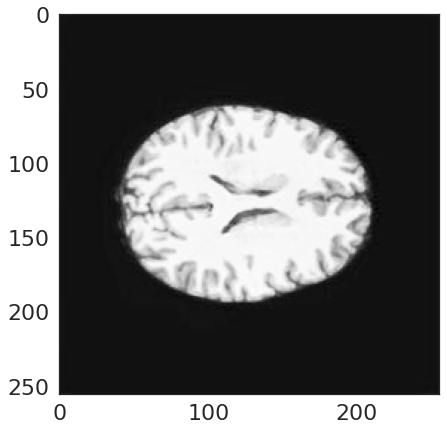

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np1.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

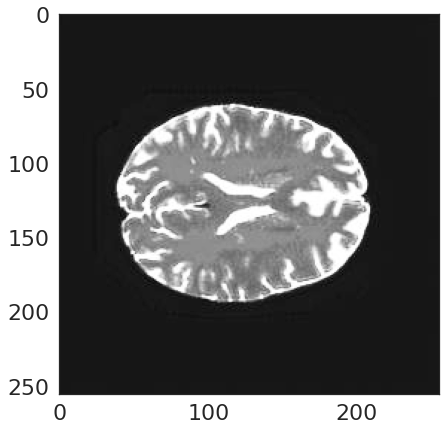

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np1.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

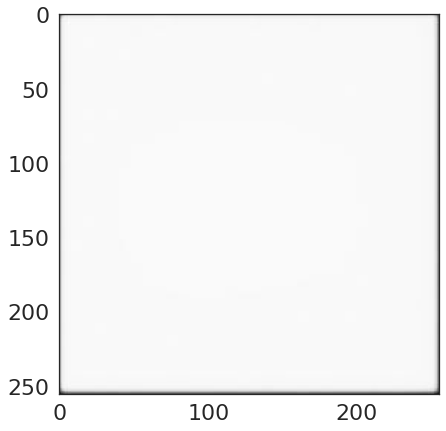

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r3_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

In [ ]:
u1 = unet_lst[0][0][0]
u2 = unet_lst[0][0][1]

IndexError: ignored

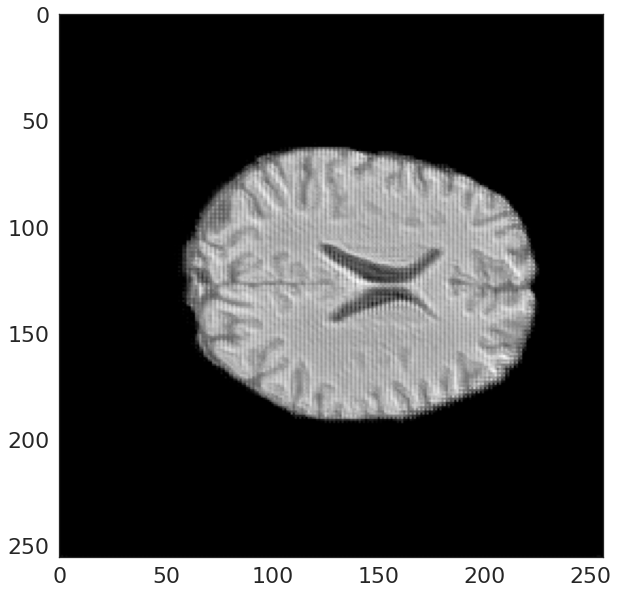

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[0, 14, :, :], cmap="Greys_r")

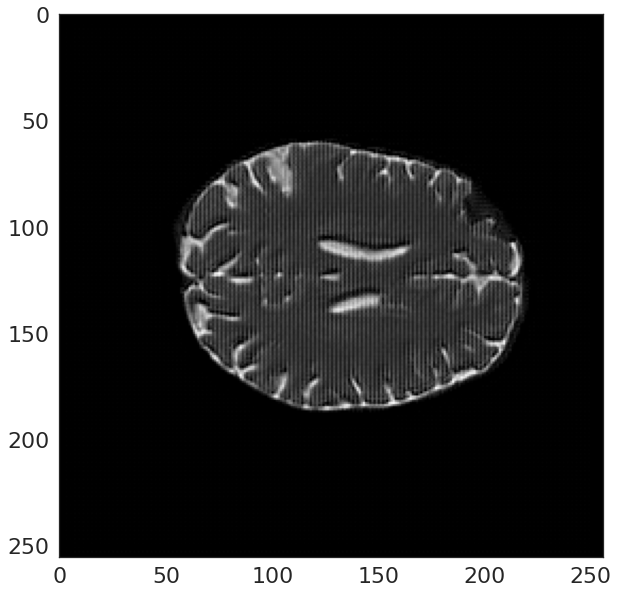

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u2[0, 12, :, :], cmap="Greys_r")

In [ ]:
b1 = beta_lst[0][0]
b2 = beta_lst[0][1]

TypeError: ignored

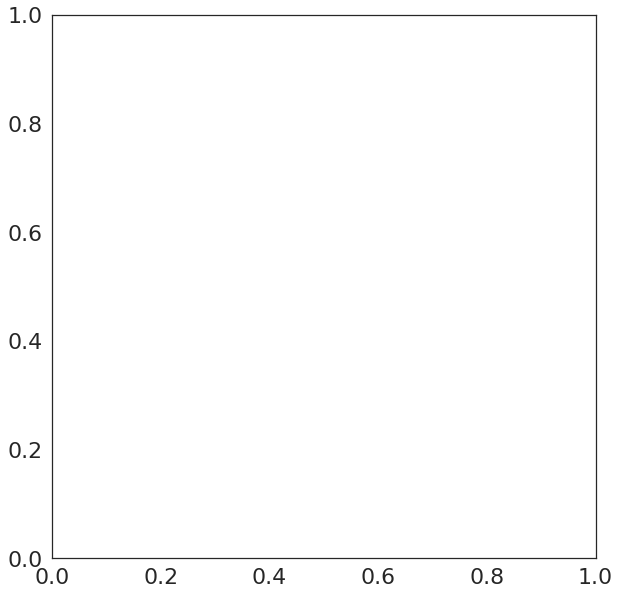

In [ ]:
plt.imshow(b1[0, 1 :, :], cmap="Greys_r")

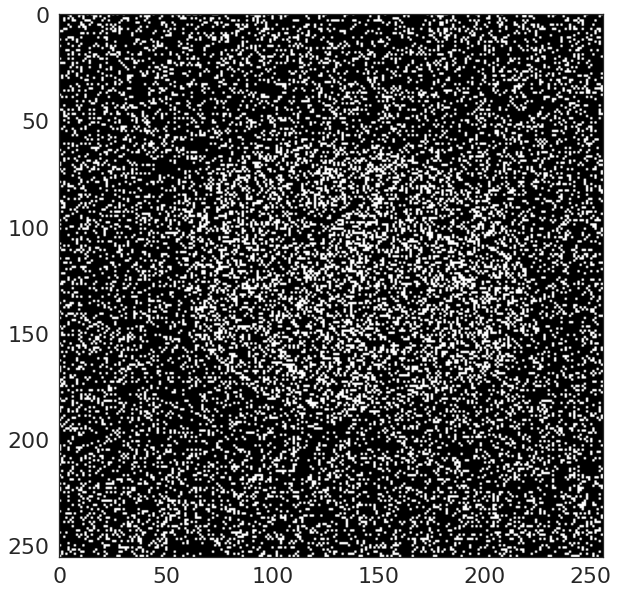

In [ ]:
plt.imshow(b2[0, 1, :, :], cmap="Greys_r")

# Validation and visualization

* It is evident that even though we can extract theta, although betas fail in extracing anatomy at the quality mentioned in the paper.
* Of course the betas are not completely waste there is some pattern but not upto standards as mentioned in the paper.
* This impacts the input to decoder Unet hence the output image as well, the output image just hase the blob shape of brain but doesn't have the brains anatomy

In [67]:
inference_generator = Data.DataLoader(IntramodalInferenceDatasetwthpreprocess(file_names_my_t1, file_names_my_t2, 1), batch_size=1,shuffle=False,drop_last=True)

In [76]:
del encoder_unet_model_inference, decoder_unet_model_inference, betahead_inference, thetahead_inference, randomizehead_inference, reconstructionhead_inference
torch.cuda.empty_cache()

In [77]:
encoder_unet_model_inference = UNet(1, 16, bilinear=False).to("cuda")
decoder_unet_model_inference = UNet(6, 16, bilinear=False).to("cuda")
betahead_inference = BetaHead(16, 5, 1).to("cuda")
thetahead_inference = ThetaHead(16, 1).to("cuda")
randomizehead_inference = RandomizationHeadnew(5, 1).to("cuda")
reconstructionhead_inference = ReconstructionHead(16, 5, 1).to("cuda")

In [ ]:
# encoder_unet_model = UNet(1, 16, bilinear=False).to("cuda")
# betahead = BetaHead(16, Cb=5, Ct=1).to("cuda")
# thetahead = ThetaHead(16, Ct=1).to("cuda")

# # betacomparehead = ReconstructionHead(5, 5, 1).to("cuda")
# randomizehead = RandomizationHead(Cb=5, Ct=1).to("cuda")

# decoder_unet_model = UNet(6, 16, bilinear=False).to("cuda")
# reconstructionhead = ReconstructionHead(16, 5, 1).to("cuda")

In [ ]:
encoder_unet_model_inference = UNet(1, 16).to("cuda")
decoder_unet_model_inference = UNet(17, 16).to("cuda")
betahead_inference = BetaHead(16, 5, 1).to("cuda")
thetahead_inference = ThetaHead(16, 1).to("cuda")
randomizehead_inference = RandomizationHeadnew(16, 1).to("cuda")
reconstructionhead_inference = ReconstructionHead(16, 5, 1).to("cuda")

In [78]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/disentangled_latent_space/latent_space_harmonization_v14_150.pth')

encoder_unet_model_inference.load_state_dict(checkpoint['encoder_unet_model'])
decoder_unet_model_inference.load_state_dict(checkpoint['decoder_unet_model'])
# decoder_unet_model_inference = decoder_unet_model
betahead_inference.load_state_dict(checkpoint['betahead'])
thetahead_inference.load_state_dict(checkpoint['thetahead'])
# randomizehead_inference.load_state_dict(checkpoint['randomizehead'])
reconstructionhead_inference.load_state_dict(checkpoint["reconstructionhead"])

encoder_unet_model_inference.eval()
decoder_unet_model_inference.eval()
betahead_inference.eval()
thetahead_inference.eval()
randomizehead_inference.eval()
reconstructionhead_inference.eval()


ReconstructionHead(
  (reconstruction_head): Sequential(
    (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
def inference_run(epoch=1):
  example_number = 0
  beta_np_lst = []
  unet_lst = []
  probmaps_np_lst = []
  for X,Y,P,Q in inference_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    u_x = encoder_unet_model_inference(X)
    p_x, o_x, s_x = betahead_inference(u_x, hard_flag=True, tau=0.1)
    t_x  = thetahead_inference(u_x)
    print(u_x.shape)
    print(t_x)

    unet_lst.append(u_x.detach().cpu().numpy())

    u_y = encoder_unet_model_inference(Y)
    p_y, o_y, s_y = betahead_inference(u_y, hard_flag=True, tau=0.1)
    t_y  = thetahead_inference(u_y)
    print(t_y)

    unet_lst.append(u_y.detach().cpu().numpy())

    # theta1_reconstructed = t_x.repeat(1, 128, 128).reshape(x_size[0], 1, 128, 128)
    # theta2_reconstructed = t_y.repeat(1, 128, 128).reshape(x_size[0], 1, 128, 128)

    # input_recon1 = torch.cat((o_x, theta1_reconstructed), 1)
    # input_recon2 = torch.cat((o_x, theta2_reconstructed), 1)
    # input_recon3 = torch.cat((o_y, theta1_reconstructed), 1)
    # input_recon4 = torch.cat((o_y, theta2_reconstructed), 1)

    input_recon1, input_recon2, input_recon3, input_recon4 = randomizehead_inference(o_x, o_y, t_x, t_y)

    d1 = decoder_unet_model_inference(input_recon1)
    d2 = decoder_unet_model_inference(input_recon2)
    d3 = decoder_unet_model_inference(input_recon3)
    d4 = decoder_unet_model_inference(input_recon4)

    unet_lst.append(d1.detach().cpu().numpy())
    beta_np_lst.append([o_x.detach().cpu().numpy(), o_y.detach().cpu().numpy()])

    r1 = reconstructionhead_inference(d1)
    r2 = reconstructionhead_inference(d2)
    r3 = reconstructionhead_inference(d3)
    r4 = reconstructionhead_inference(d4)

    r1_np = r1.detach().cpu().numpy()
    r2_np = r2.detach().cpu().numpy()
    r3_np = r3.detach().cpu().numpy()
    r4_np = r4.detach().cpu().numpy()

    

    p_y_np = p_y.detach().cpu().numpy()
    p_x_np = p_x.detach().cpu().numpy()
    probmaps_np_lst.append([p_x_np, p_y_np])

    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np'+str(example_number)+".jpg", r1_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np'+str(example_number)+".jpg", r2_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r3_np'+str(example_number)+".jpg", r3_np[0, 0, :, :])
    imageio.imwrite('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r4_np'+str(example_number)+".jpg", r4_np[0, 0, :, :])

    del X, Y, u_x, p_x, t_x, u_y, p_y, t_y, input_recon1, input_recon2, input_recon3, input_recon4, r1, r2, r3, r4, d1,d2, d3, d4
    torch.cuda.empty_cache()    
    example_number = example_number + 1

    if(example_number > 4):
      break;
    
  
  return beta_np_lst, unet_lst, probmaps_np_lst

In [79]:
beta_lst, unet_lst, probmaps_np_lst = inference_run(epoch=1)

torch.Size([1, 16, 256, 256])
tensor([[-78.3038]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-8.4724]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-103.2864]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-26.9924]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-96.1469]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-8.3135]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-93.7411]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-23.8225]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([1, 16, 256, 256])
tensor([[-88.6649]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-10.7326]], device='cuda:0', grad_fn=<AddmmBackward>)


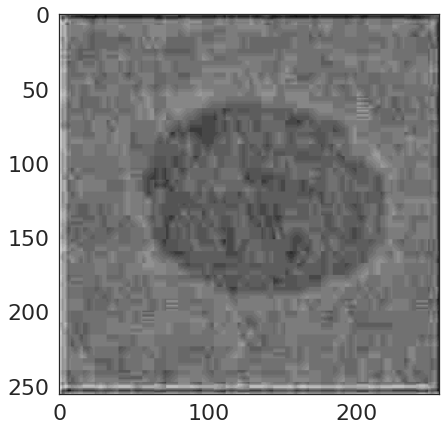

In [80]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

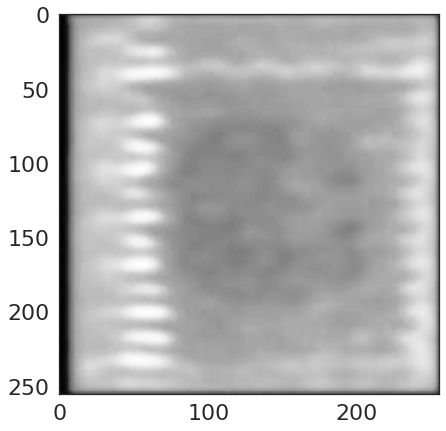

In [82]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

Pretrained UNET Output

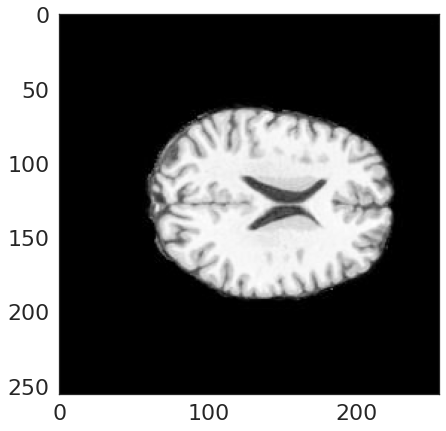

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

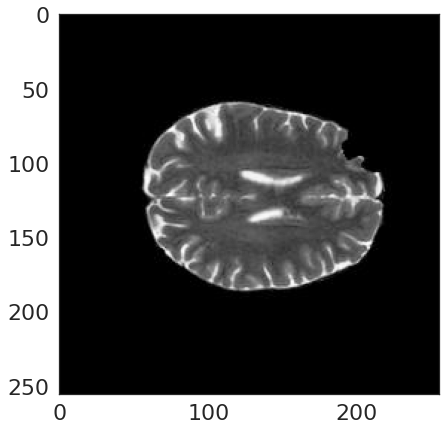

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

In [ ]:
mynb_np1= load_4D(file_names_t1[0], slicenum=64)
mynb_np1 = imgnorm(mynb_np1)
mynb_np1 = mynb_np1[0,:,:]
mynb_np2 = load_4D(file_names_t1[4], slicenum=64)
mynb_np2 = imgnorm(mynb_np2)
mynb_np2 = mynb_np2[0,:,:]
vol_shape = (128, 128, 128)

In [ ]:
mynb_np1= load_3D(file_names_my_t1[1])
mynb_np1 = mynb_np1[0,:,:]
mynb_np2 = load_3D(file_names_my_t2[1])
mynb_np2 = mynb_np2[0,:,:]


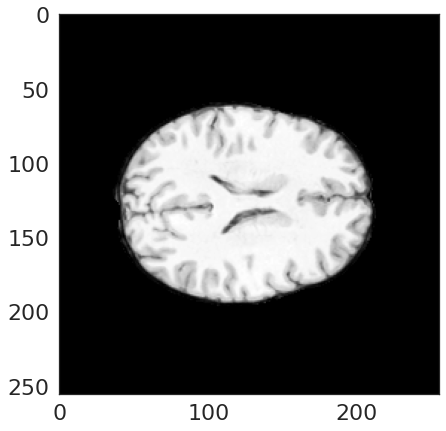

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(mynb_np1, cmap="Greys_r")

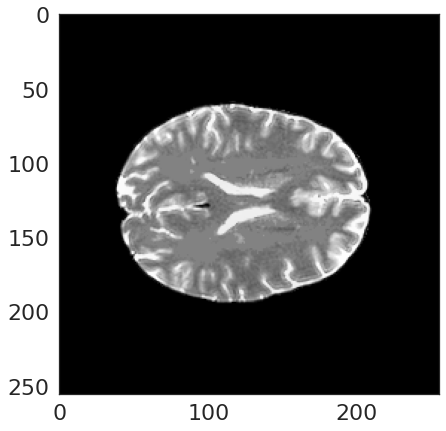

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(mynb_np2, cmap="Greys_r")

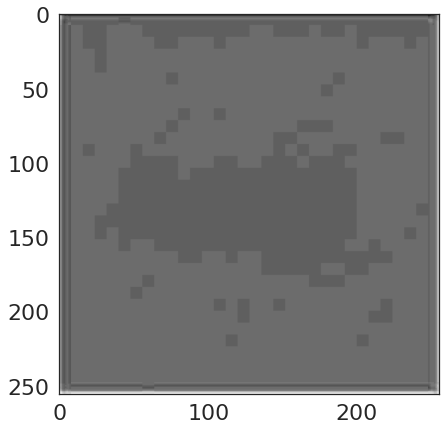

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

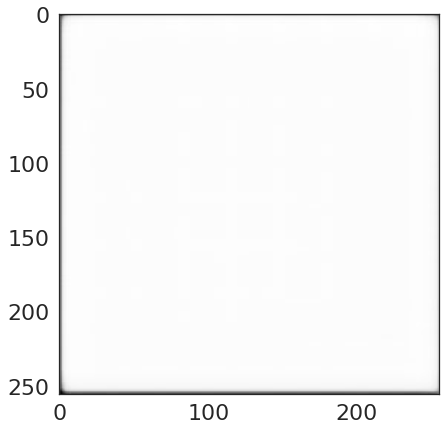

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

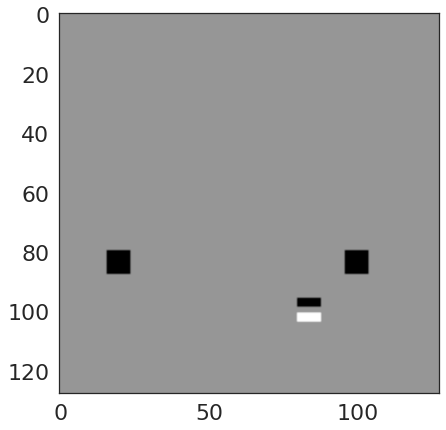

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

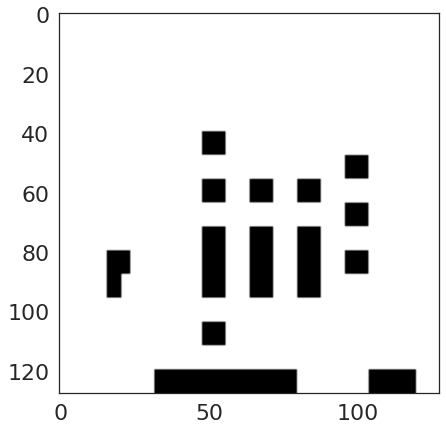

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

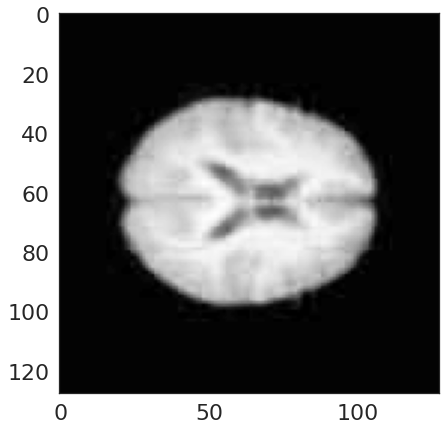

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r2_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

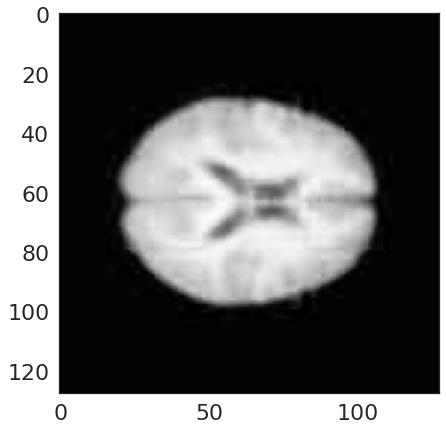

In [ ]:
from PIL import Image
image = Image.open('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/r1_np0.jpg')
data = np.asfarray(image)
plt.figure(figsize=(7,7))
plt.imshow(data, cmap="Greys_r")

In [84]:
u1 = unet_lst[0][0]
u2 = unet_lst[1][0]
u3 = unet_lst[2][0]

In [ ]:
beta_lst

[]

In [85]:
b1 = beta_lst[0][0]
b2 = beta_lst[0][1]

In [86]:
p1 = probmaps_np_lst[0][0]
p2 = probmaps_np_lst[0][1]

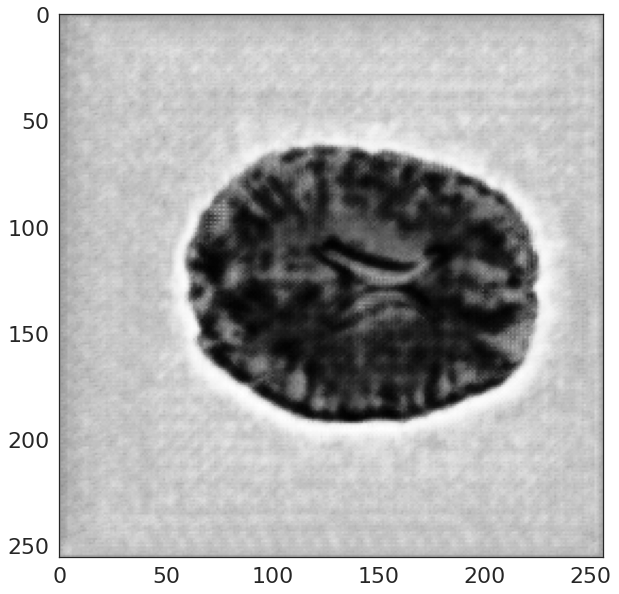

In [88]:
plt.figure(figsize=(10,10))
plt.imshow(p1[0, 3, :, :], cmap="Greys_r")

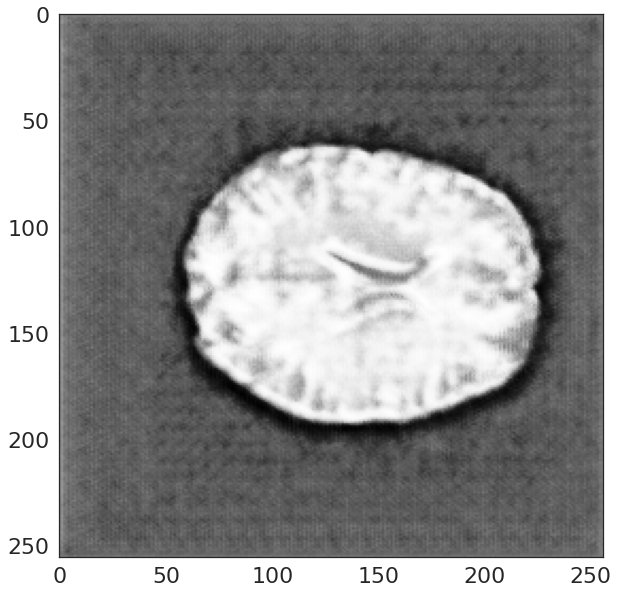

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(p1[0, 4, :, :], cmap="Greys_r")

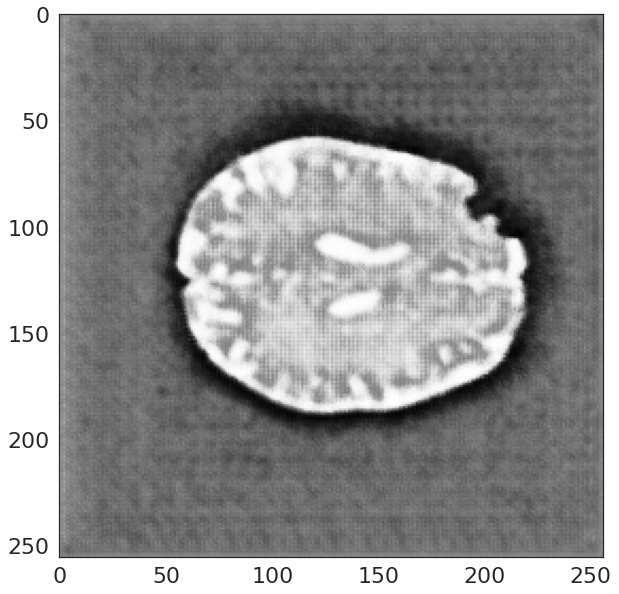

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(p2[0, 2, :, :], cmap="Greys_r")

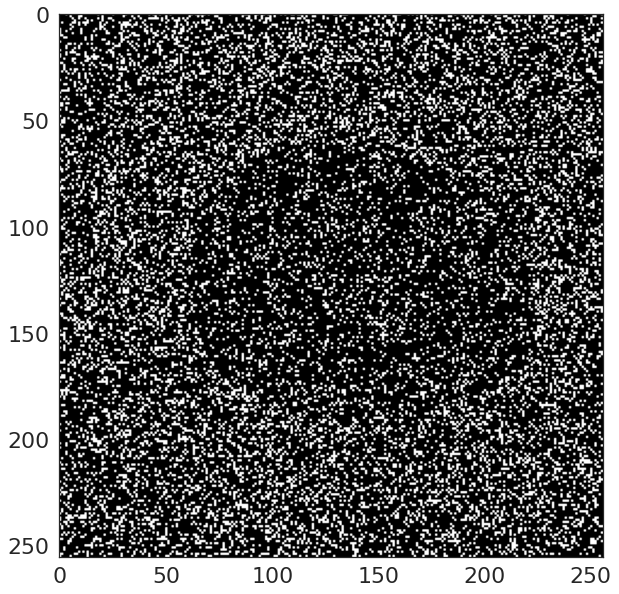

In [89]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 1,:, :], cmap="Greys_r")

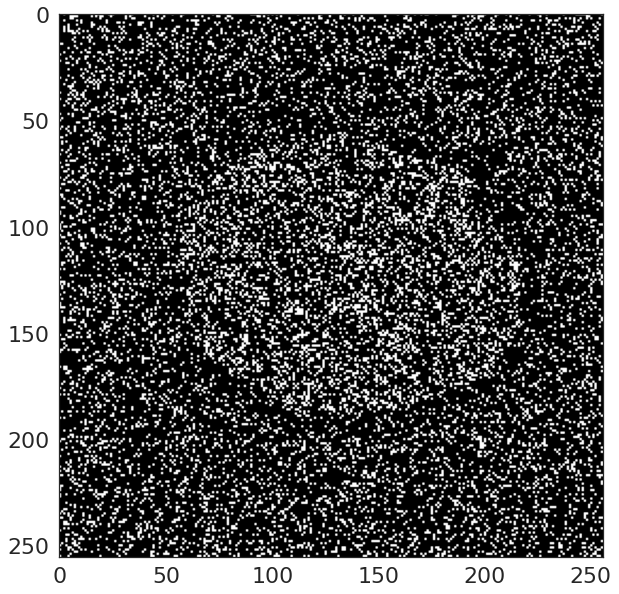

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(b2[0, 4,:, :], cmap="Greys_r")

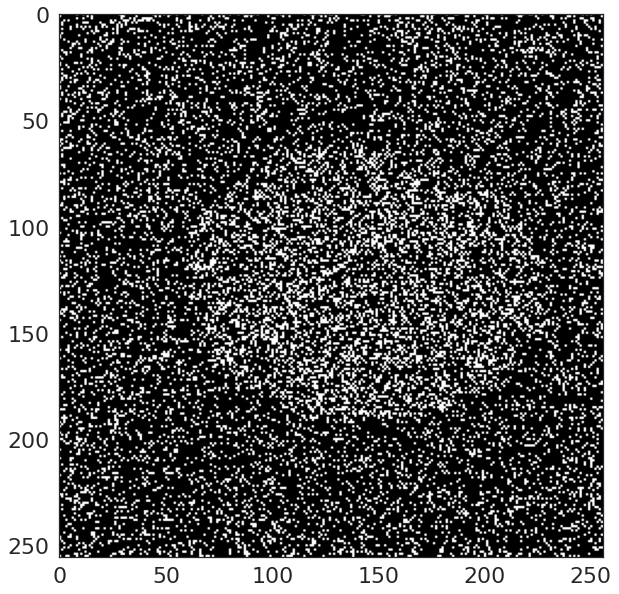

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 4,:, :], cmap="Greys_r")

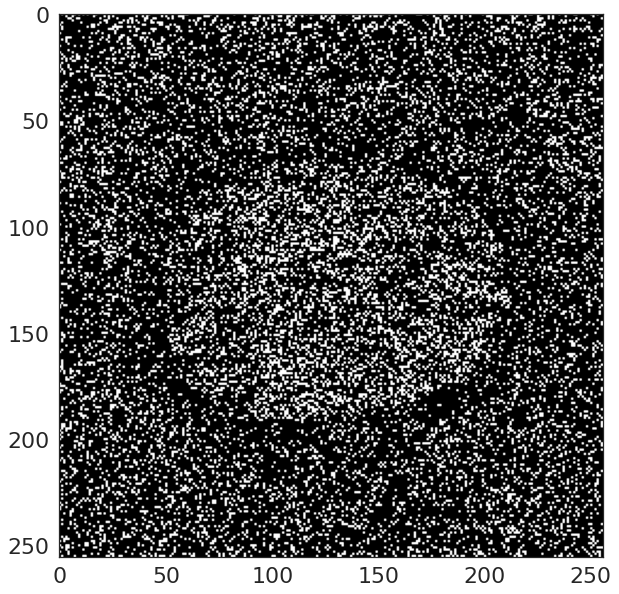

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b2[0, 3, :, :], cmap="Greys_r")

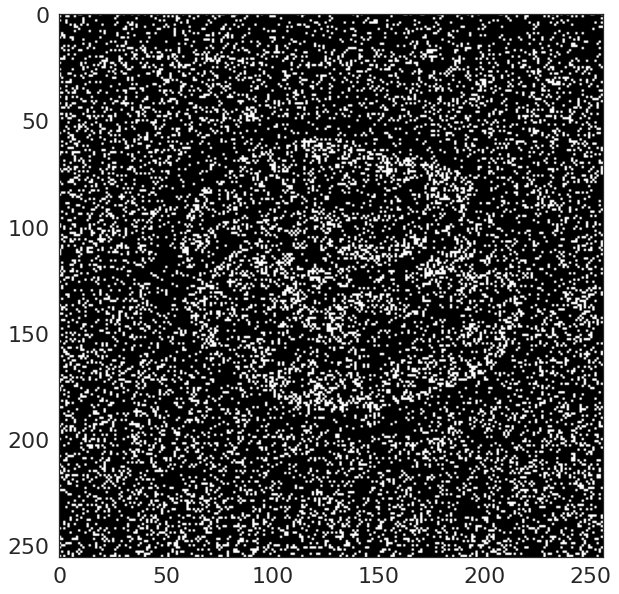

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b2[0, 4,:, :], cmap="Greys_r")

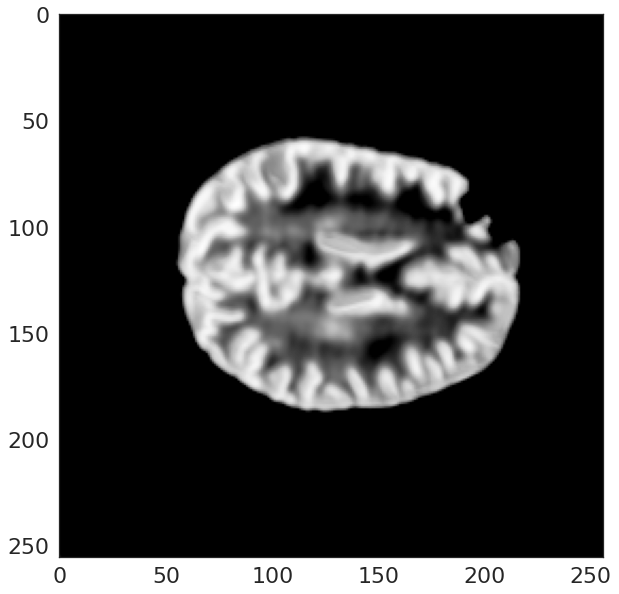

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u2[ 10 ,  :, :],  cmap="Greys_r")

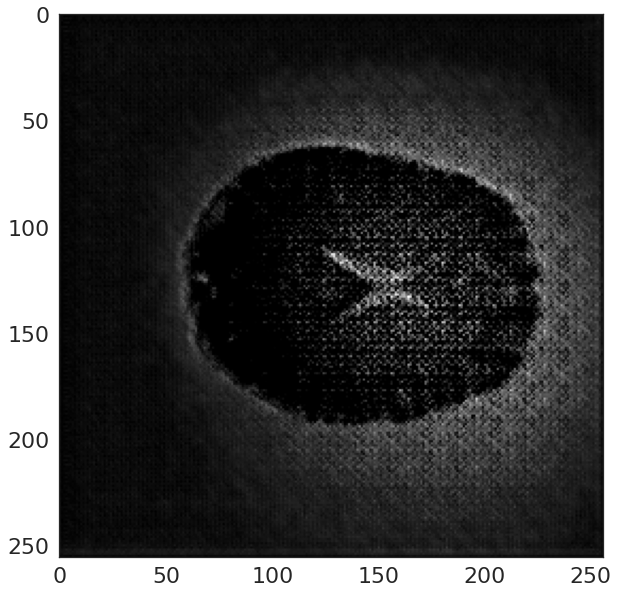

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[5, :, :],  cmap="Greys_r")

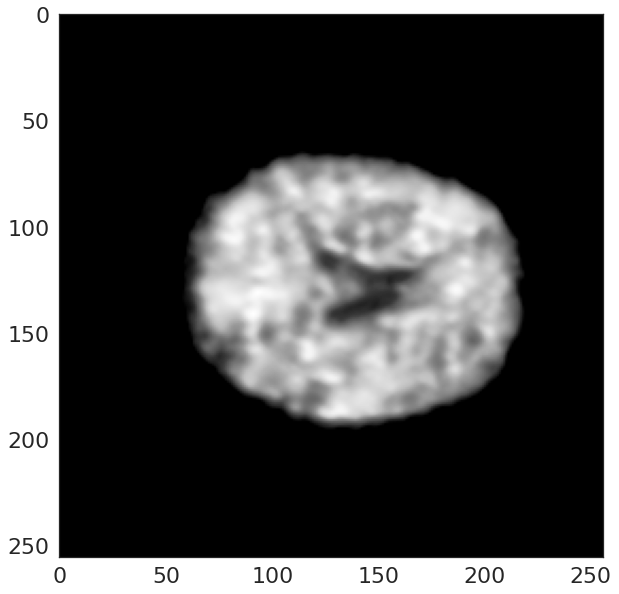

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u3[ 8 , :, :],  cmap="Greys_r")

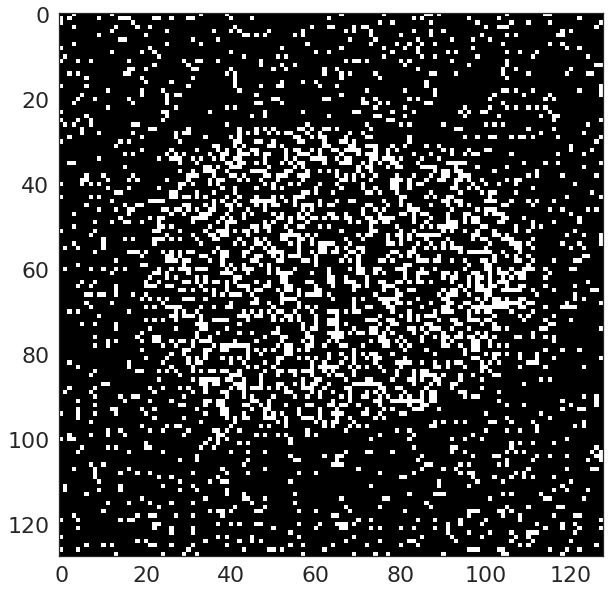

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 2,:, :], cmap="Greys_r")

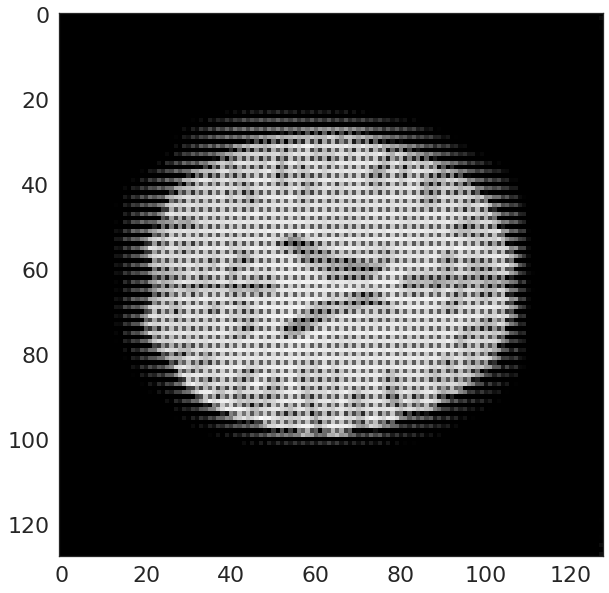

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u2[6,:, :],  cmap="Greys_r")

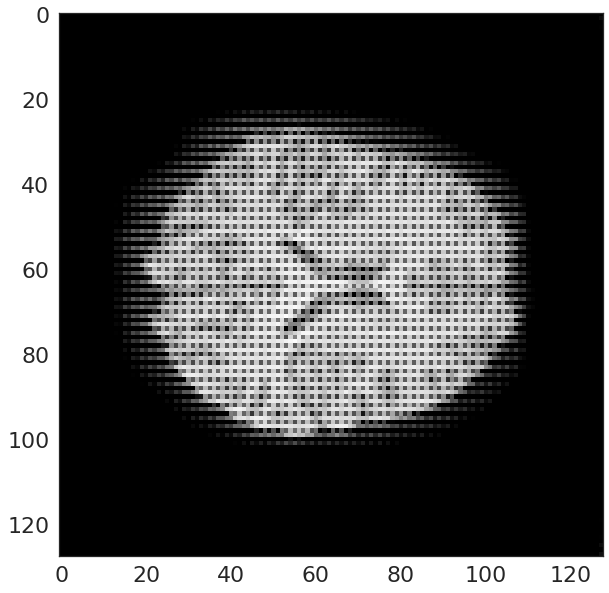

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[6,:, :],  cmap="Greys_r")

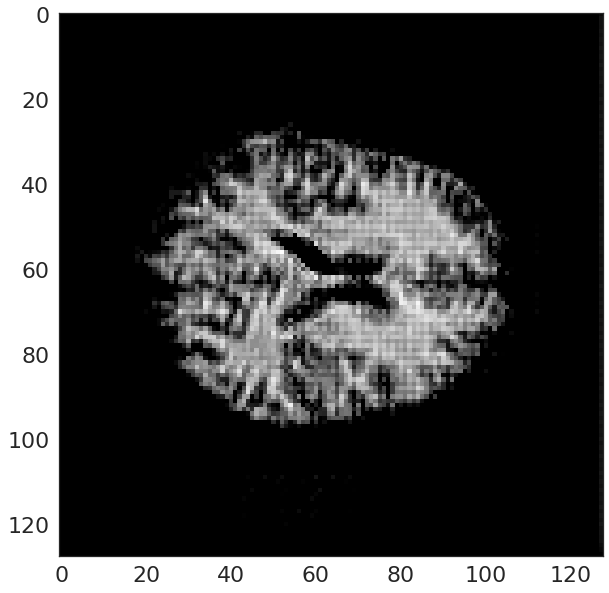

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[10,:, :],  cmap="Greys_r")

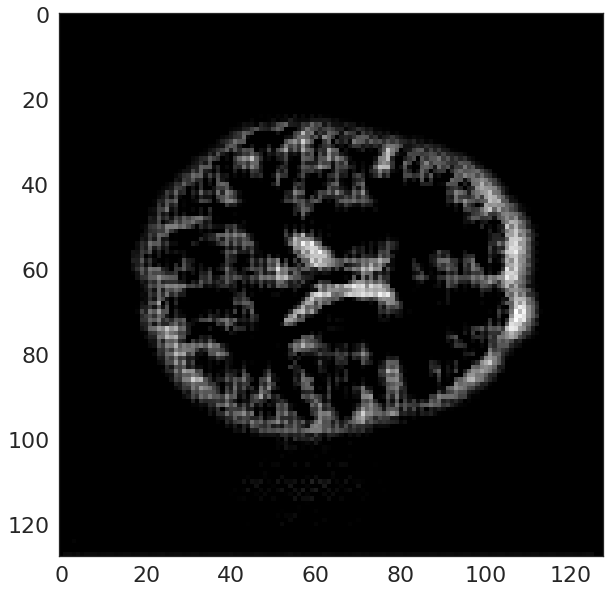

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[3,:, :],  cmap="Greys_r")

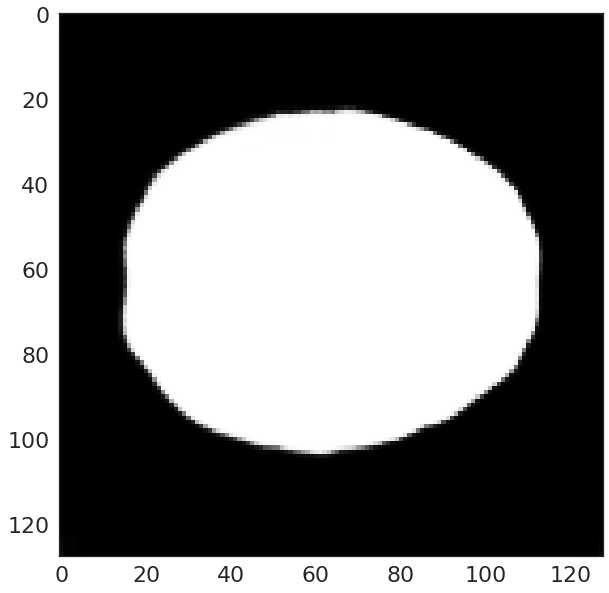

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(p1[0, 2,:, :], cmap="Greys_r")

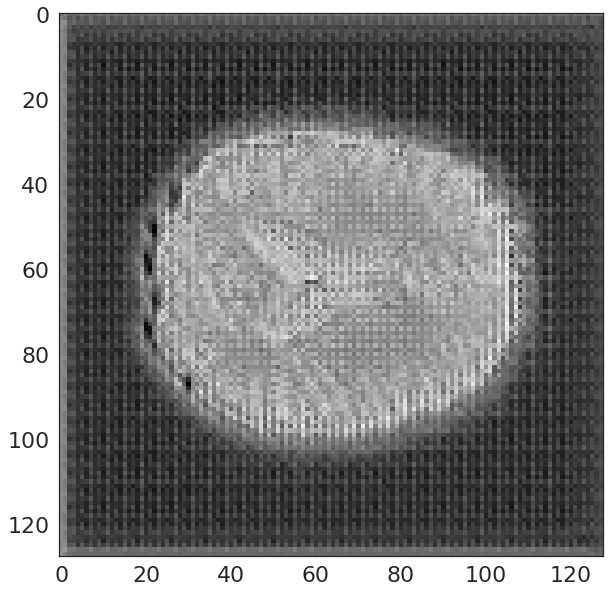

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(p2[0, 0, :, :], cmap="Greys_r")

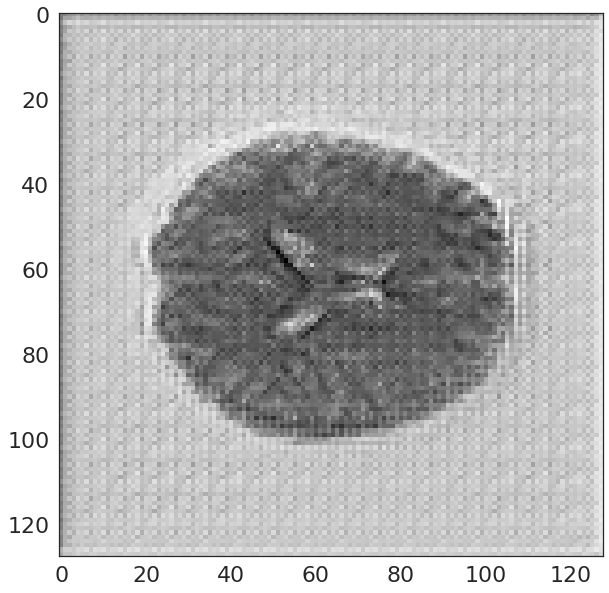

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 1,:, :], cmap="Greys_r")

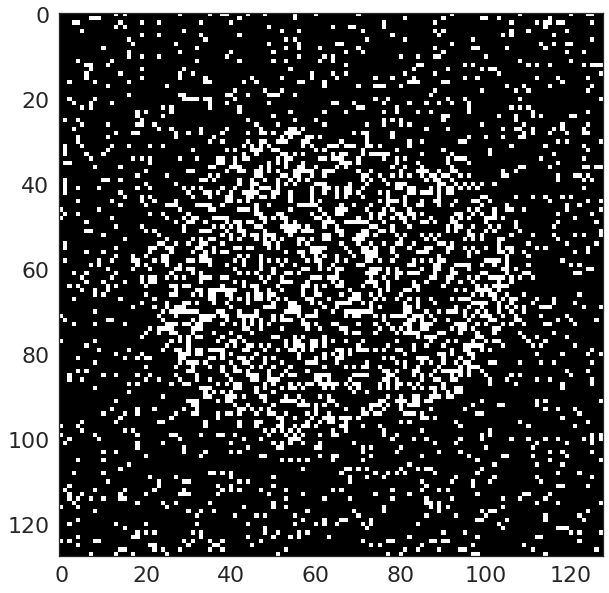

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 4,:, :], cmap="Greys_r")

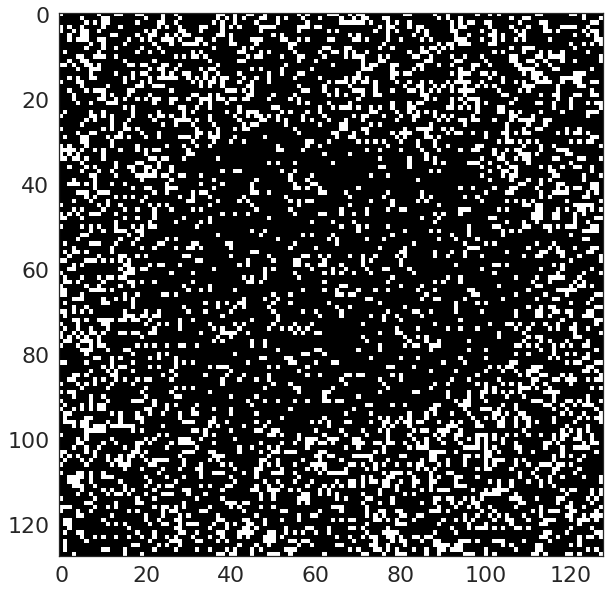

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 3,:, :], cmap="Greys_r")

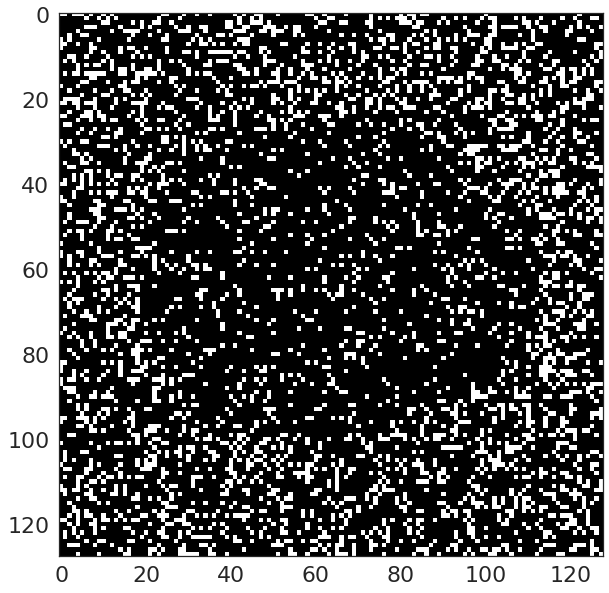

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b2[0, 3,:, :], cmap="Greys_r")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b1[0, 0,:, :], cmap="Greys_r")

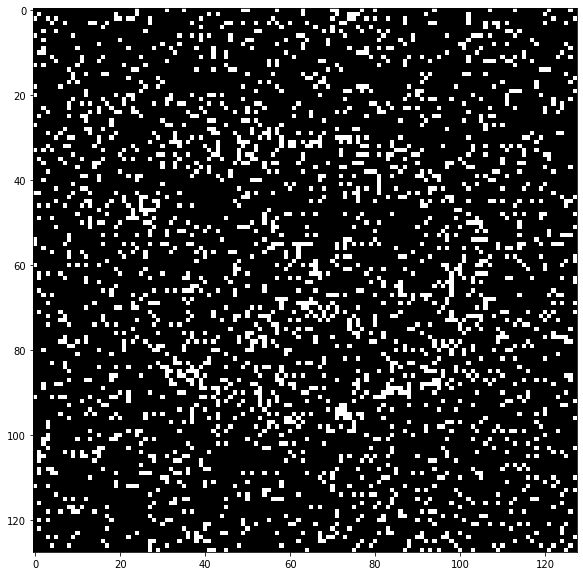

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b2[0, 3,:, :], cmap="Greys_r")

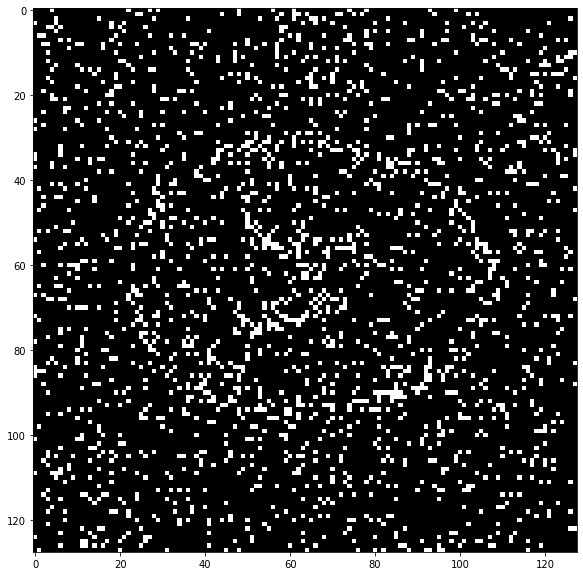

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(b2[0, 1,:, :], cmap="Greys_r")

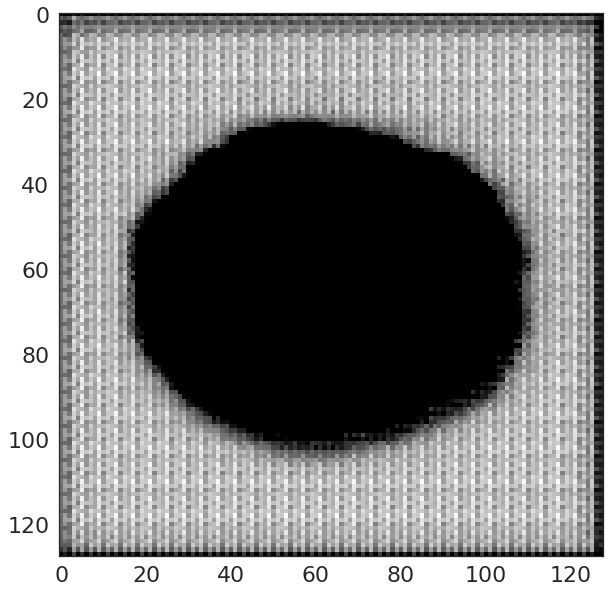

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[ 10, :, :],  cmap="Greys_r")

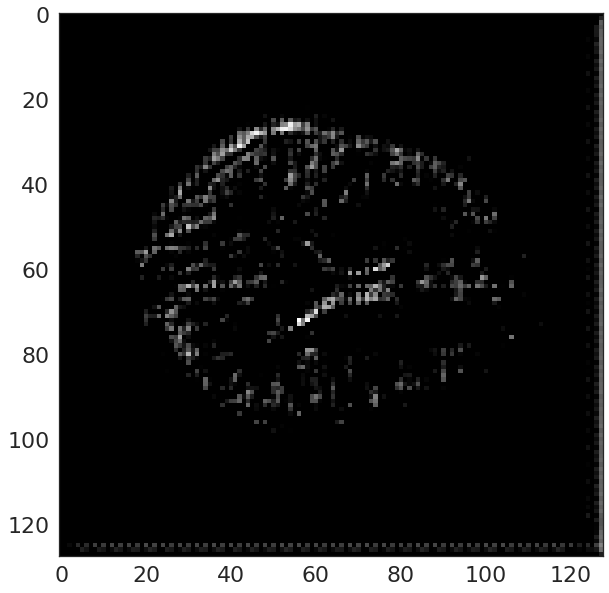

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[10,:, :],  cmap="Greys_r")

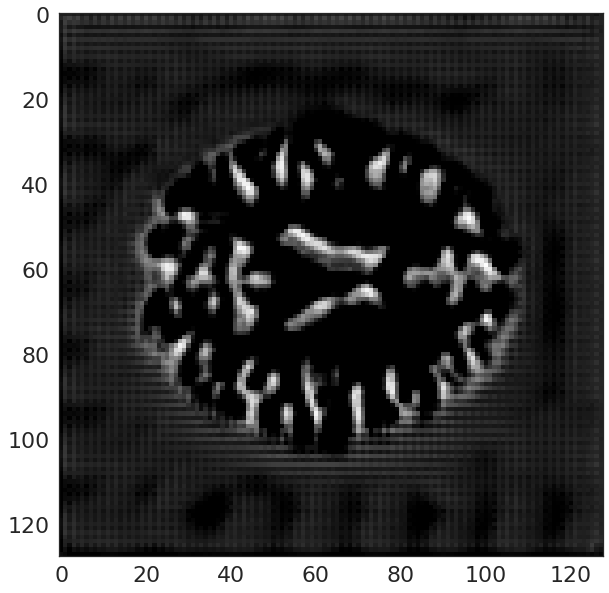

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u2[1,:, :],  cmap="Greys_r")

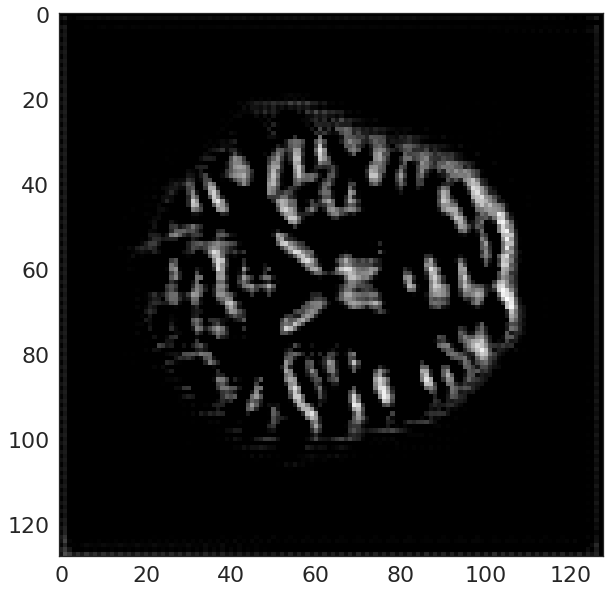

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[5,:, :],  cmap="Greys_r")

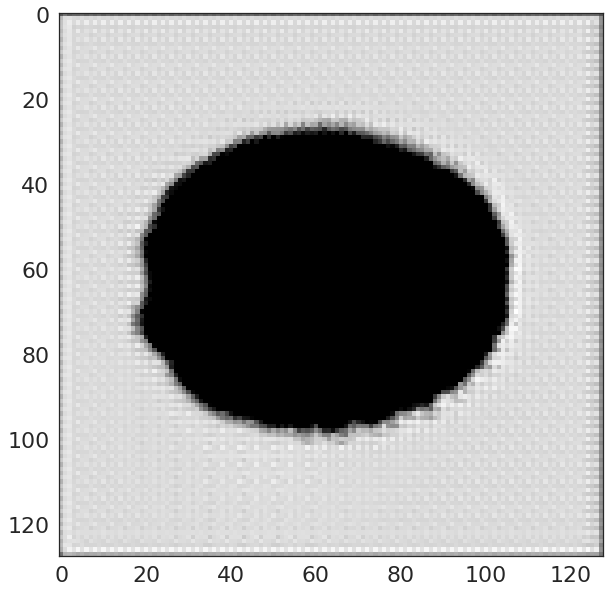

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u2[15,:, :],  cmap="Greys_r")

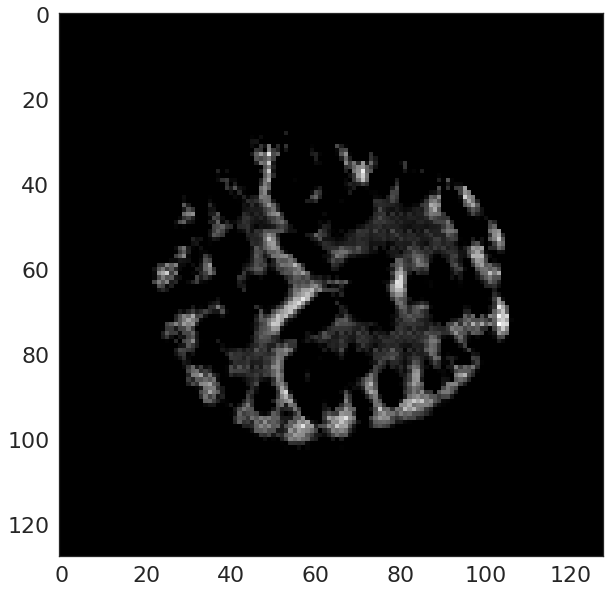

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u1[7,:, :],  cmap="Greys_r")

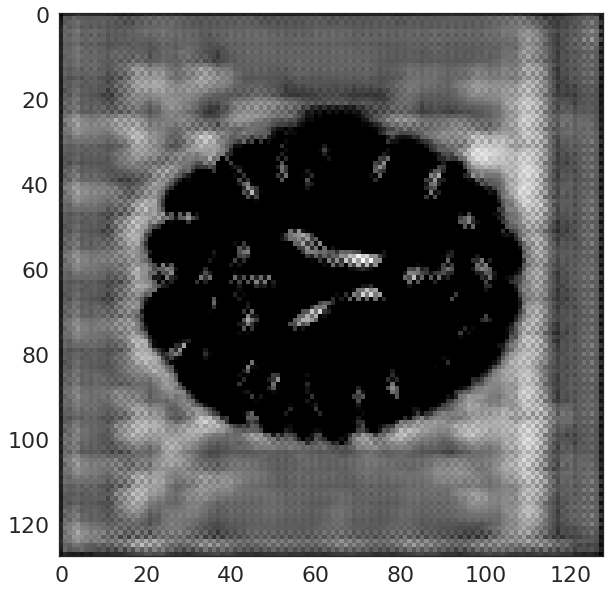

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u2[7,:, :], cmap="Greys_r")

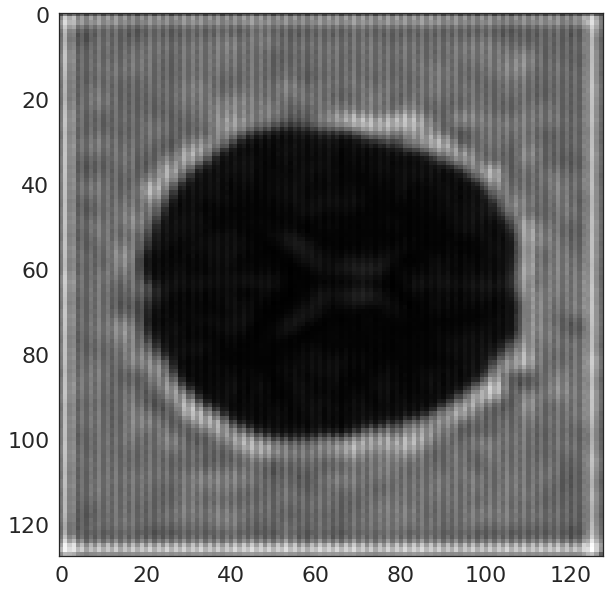

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(u3[10,:, :], cmap="Greys_r")

In [ ]:
hist,bins = np.histogram(b1[0,1,:, :].ravel(),128,[0,1])

In [ ]:
hist

array([10347,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,  6037]

In [ ]:
bins

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 